<a href="https://colab.research.google.com/github/maanavgoyal/Mario-RL-Agent/blob/main/mario2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Setting up basic libraries

In [1]:
!pip install nes-py==0.2.6
!pip install gym-super-mario-bros
!pip install opencv-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached nes_py-0.2.6.tar.gz (75 kB)
  Using cached pygame-2.1.2-cp37-cp37m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (21.8 MB)
  Created wheel for nes-py: filename=nes_py-0.2.6-cp37-cp37m-linux_x86_64.whl size=168639 sha256=b4a76693e332dfb71b4c77819fa5dd701021ba5e27351a2a6c3197754264aac6
  Stored in directory: /root/.cache/pip/wheels/cf/87/a9/d777bc0614683325afc2501fe16a01ae29a9bf6c5650cffbad
Successfully built nes-py
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 199 kB 4.9 MB/s 
     |████████████████████████████████| 77 kB 246 kB/s 
  Created wheel for nes-py: filename=nes_py-8.2.1-cp37-cp37m-linux_x86_64.whl size=437216 sha256=ee50bdc35bfe47c7fa84fe1ad9eca198a4abb33b89a50485591be575a9005506
  Stored in directory: /root/.cache/pip/wheels/17/96/0e/22a8c7dbdf412d8e988286f223b223baf0f4a

In [2]:
import torch
import torch.nn as nn
import random
from tqdm import tqdm
import pickle
import numpy as np
import collections 
import cv2
import matplotlib.pyplot as plt

Gym and wrappers import

In [3]:
import gym
import gym_super_mario_bros
from nes_py.wrappers import JoypadSpace
from gym_super_mario_bros.actions import SIMPLE_MOVEMENT

Game Setup

In [4]:
env = gym_super_mario_bros.make('SuperMarioBros-v3')
env = JoypadSpace(env, SIMPLE_MOVEMENT)

In [5]:
state=env.reset()

Render Game (works in VS code but not in Colab)

In [ ]:
# Create a flag - restart or not
done = True
# Loop through each frame in the game
for step in range(100000): 
    # Start the game to begin with 
    if done: 
        # Start the gamee
        env.reset()
    # Do random actions
    state, reward, done, info = env.step(env.action_space.sample())
    # Show the game on the screen
    env.render()
# Close the game
env.close()

In [ ]:
env.close()

Preprocessing

*   Skipping frames for our AI to learn from as consecutive frames may not offer too much relevant information
*   Converting RGB frames to greyscale so that the AI has much less data to deal with
*   Restricting the action space to basic 7 controls
*   Normalising the pixel value in greyscale





In [7]:
class SkipFrame(gym.Wrapper):
    def __init__(self, env=None, skip=4):
        """Return only every `skip`-th frame"""
        super(SkipFrame, self).__init__(env)
        # most recent raw observations (for max pooling across time steps)
        self._obs_buffer = collections.deque(maxlen=2)
        self._skip = skip

    def step(self, action):
        total_reward = 0.0
        done = None
        for _ in range(self._skip):
            obs, reward, done, info = self.env.step(action)
            self._obs_buffer.append(obs)
            total_reward += reward
            if done:
                break
        max_frame = np.max(np.stack(self._obs_buffer), axis=0)
        return max_frame, total_reward, done, info

    def reset(self):
        self._obs_buffer.clear()
        obs = self.env.reset()
        self._obs_buffer.append(obs)
        return obs

class ImageToPyTorch(gym.ObservationWrapper):
    def __init__(self, env):
        super(ImageToPyTorch, self).__init__(env)
        old_shape = self.observation_space.shape
        self.observation_space = gym.spaces.Box(low=0.0, high=1.0, shape=(old_shape[-1], old_shape[0], old_shape[1]),
                                                dtype=np.float32)

    def observation(self, observation):
        return np.moveaxis(observation, 2, 0)


class ScaledFloatFrame(gym.ObservationWrapper):
    """Normalize pixel values in frame --> 0 to 1"""
    def observation(self, obs):
        return np.array(obs).astype(np.float32) / 255.0

class ProcessFrame(gym.ObservationWrapper):
    """
    Downsamples image to 84x84
    Greyscales image

    Returns numpy array
    """
    def __init__(self, env=None):
        super(ProcessFrame, self).__init__(env)
        self.observation_space = gym.spaces.Box(low=0, high=255, shape=(84, 84, 1), dtype=np.uint8)

    def observation(self, obs):
        return ProcessFrame.process(obs)

    @staticmethod
    def process(frame):
        if frame.size == 240 * 256 * 3:
            img = np.reshape(frame, [240, 256, 3]).astype(np.float32)
        else:
            assert False, "Unknown resolution."
        img = img[:, :, 0] * 0.299 + img[:, :, 1] * 0.587 + img[:, :, 2] * 0.114
        resized_screen = cv2.resize(img, (84, 110), interpolation=cv2.INTER_AREA)
        x_t = resized_screen[18:102, :]
        x_t = np.reshape(x_t, [84, 84, 1])
        return x_t.astype(np.uint8)

def make_env(env):
    env = SkipFrame(env)
    env = ProcessFrame(env)
    env = ImageToPyTorch(env)
    env = ScaledFloatFrame(env)
    return JoypadSpace(env, SIMPLE_MOVEMENT)

In [8]:
env = gym_super_mario_bros.make('SuperMarioBros-v3')
env = make_env(env)

In [9]:
state=env.reset()
state.shape

(1, 84, 84)

DQN algorithm

In [10]:
class DQNSolver(nn.Module):

    def __init__(self, input_shape, n_actions):
        super(DQNSolver, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(input_shape[0], 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU()
        )

        conv_out_size = self._get_conv_out(input_shape)
        self.fc = nn.Sequential(
            nn.Linear(conv_out_size, 512),
            nn.ReLU(),
            nn.Linear(512, n_actions)
        )
    
    def _get_conv_out(self, shape):
        o = self.conv(torch.zeros(1, *shape))
        return int(np.prod(o.size()))

    def forward(self, x):
        conv_out = self.conv(x).view(x.size()[0], -1)
        return self.fc(conv_out)
    

class DQNAgent:

    def __init__(self, state_space, action_space, max_memory_size, batch_size, gamma, lr,
                 dropout, exploration_max, exploration_min, exploration_decay, double_dq, pretrained):

        # Define DQN Layers
        self.state_space = state_space
        self.action_space = action_space
        self.double_dq = double_dq
        self.pretrained = pretrained
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        if self.double_dq:  
            self.local_net = DQNSolver(state_space, action_space).to(self.device)
            self.target_net = DQNSolver(state_space, action_space).to(self.device)
            
            if self.pretrained:
                self.local_net.load_state_dict(torch.load("dq1.pt", map_location=torch.device(self.device)))
                self.target_net.load_state_dict(torch.load("dq2.pt", map_location=torch.device(self.device)))
                    
            self.optimizer = torch.optim.Adam(self.local_net.parameters(), lr=lr)
            self.copy = 5000  # Copy the local model weights into the target network every 5000 steps
            self.step = 0
        else:  
            self.dqn = DQNSolver(state_space, action_space).to(self.device)
            
            if self.pretrained:
                self.dqn.load_state_dict(torch.load("dq.pt", map_location=torch.device(self.device)))
            self.optimizer = torch.optim.Adam(self.dqn.parameters(), lr=lr)

        # Create memory
        self.max_memory_size = max_memory_size
        if self.pretrained:
            self.STATE_MEM = torch.load("STATE_MEM.pt")
            self.ACTION_MEM = torch.load("ACTION_MEM.pt")
            self.REWARD_MEM = torch.load("REWARD_MEM.pt")
            self.STATE2_MEM = torch.load("STATE2_MEM.pt")
            self.DONE_MEM = torch.load("DONE_MEM.pt")
            with open("ending_position.pkl", 'rb') as f:
                self.ending_position = pickle.load(f)
            with open("num_in_queue.pkl", 'rb') as f:
                self.num_in_queue = pickle.load(f)
        else:
            self.STATE_MEM = torch.zeros(max_memory_size, *self.state_space)
            self.ACTION_MEM = torch.zeros(max_memory_size, 1)
            self.REWARD_MEM = torch.zeros(max_memory_size, 1)
            self.STATE2_MEM = torch.zeros(max_memory_size, *self.state_space)
            self.DONE_MEM = torch.zeros(max_memory_size, 1)
            self.ending_position = 0
            self.num_in_queue = 0
        
        self.memory_sample_size = batch_size
        
        # Learning parameters
        self.gamma = gamma
        self.l1 = nn.SmoothL1Loss().to(self.device) # Also known as Huber loss
        self.exploration_max = exploration_max
        self.exploration_rate = exploration_max
        self.exploration_min = exploration_min
        self.exploration_decay = exploration_decay

    def remember(self, state, action, reward, state2, done):
        self.STATE_MEM[self.ending_position] = state.float()
        self.ACTION_MEM[self.ending_position] = action.float()
        self.REWARD_MEM[self.ending_position] = reward.float()
        self.STATE2_MEM[self.ending_position] = state2.float()
        self.DONE_MEM[self.ending_position] = done.float()
        self.ending_position = (self.ending_position + 1) % self.max_memory_size  # FIFO tensor
        self.num_in_queue = min(self.num_in_queue + 1, self.max_memory_size)
        
    def recall(self):
        # Randomly sample 'batch size' experiences
        idx = random.choices(range(self.num_in_queue), k=self.memory_sample_size)
        
        STATE = self.STATE_MEM[idx]
        ACTION = self.ACTION_MEM[idx]
        REWARD = self.REWARD_MEM[idx]
        STATE2 = self.STATE2_MEM[idx]
        DONE = self.DONE_MEM[idx]
        
        return STATE, ACTION, REWARD, STATE2, DONE

    def act(self, state):
        # Epsilon-greedy action
        
        if self.double_dq:
            self.step += 1
        if random.random() < self.exploration_rate:  
            return torch.tensor([[random.randrange(self.action_space)]])
        if self.double_dq:
            # Local net is used for the policy
            return torch.argmax(self.local_net(state.to(self.device))).unsqueeze(0).unsqueeze(0).cpu()
        else:
            return torch.argmax(self.dqn(state.to(self.device))).unsqueeze(0).unsqueeze(0).cpu()

    def copy_model(self):
        # Copy local net weights into target net
        
        self.target_net.load_state_dict(self.local_net.state_dict())
    
    def experience_replay(self):
        
        if self.double_dq and self.step % self.copy == 0:
            self.copy_model()

        if self.memory_sample_size > self.num_in_queue:
            return

        STATE, ACTION, REWARD, STATE2, DONE = self.recall()
        STATE = STATE.to(self.device)
        ACTION = ACTION.to(self.device)
        REWARD = REWARD.to(self.device)
        STATE2 = STATE2.to(self.device)
        DONE = DONE.to(self.device)
        
        self.optimizer.zero_grad()
        if self.double_dq:
            # Double Q-Learning target is Q*(S, A) <- r + γ max_a Q_target(S', a)
            target = REWARD + torch.mul((self.gamma * 
                                        self.target_net(STATE2).max(1).values.unsqueeze(1)), 
                                        1 - DONE)

            current = self.local_net(STATE).gather(1, ACTION.long()) # Local net approximation of Q-value
        else:
            # Q-Learning target is Q*(S, A) <- r + γ max_a Q(S', a) 
            target = REWARD + torch.mul((self.gamma * 
                                        self.dqn(STATE2).max(1).values.unsqueeze(1)), 
                                        1 - DONE)
                
            current = self.dqn(STATE).gather(1, ACTION.long())
        
        loss = self.l1(current, target)
        loss.backward() # Compute gradients
        self.optimizer.step() # Backpropagate error

        self.exploration_rate *= self.exploration_decay
        
        # Makes sure that exploration rate is always at least 'exploration min'
        self.exploration_rate = max(self.exploration_rate, self.exploration_min)

In [11]:
def show_state(env, ep=0, info=""):
    plt.figure(3)
    plt.clf()
    plt.imshow(env.render(mode='rgb_array'))
    plt.title("Episode: %d %s" % (ep, info))
    plt.axis('off')

    display.clear_output(wait=True)
    display.display(plt.gcf())

Super mario gym offers us mario in different variations. Here we will test the learning of our AI for v3.
---
v0 is the standard Mario Versio whereas v3 is simplified mario reduced to pixels

In [12]:
env = gym_super_mario_bros.make('SuperMarioBros-v3')
env = make_env(env)
state=env.reset()

This is the frame after preprocessing

In [ ]:
show_state(env)

  0%|          | 1/1000 [00:05<1:23:22,  5.01s/it]

Total reward after episode 1 is 1502.0


  0%|          | 2/1000 [00:11<1:41:03,  6.08s/it]

Total reward after episode 2 is 1572.0


  0%|          | 3/1000 [00:19<1:51:19,  6.70s/it]

Total reward after episode 3 is 1968.0


  0%|          | 4/1000 [00:23<1:31:59,  5.54s/it]

Total reward after episode 4 is 686.0


  0%|          | 5/1000 [00:42<2:55:11, 10.56s/it]

Total reward after episode 5 is 2394.0


  1%|          | 6/1000 [00:47<2:21:17,  8.53s/it]

Total reward after episode 6 is 1497.0


  1%|          | 7/1000 [00:53<2:08:55,  7.79s/it]

Total reward after episode 7 is 1971.0


  1%|          | 8/1000 [01:00<2:06:17,  7.64s/it]

Total reward after episode 8 is 1495.0


  1%|          | 9/1000 [01:06<1:54:41,  6.94s/it]

Total reward after episode 9 is 1608.0


  1%|          | 10/1000 [01:11<1:45:57,  6.42s/it]

Total reward after episode 10 is 2020.0


  1%|          | 11/1000 [01:18<1:50:17,  6.69s/it]

Total reward after episode 11 is 2037.0


  1%|          | 12/1000 [01:29<2:09:49,  7.88s/it]

Total reward after episode 12 is 2209.0


  1%|▏         | 13/1000 [01:44<2:48:39, 10.25s/it]

Total reward after episode 13 is 2713.0


  1%|▏         | 14/1000 [01:50<2:24:39,  8.80s/it]

Total reward after episode 14 is 1492.0


  2%|▏         | 15/1000 [01:54<2:03:29,  7.52s/it]

Total reward after episode 15 is 1498.0


  2%|▏         | 16/1000 [02:01<1:58:59,  7.26s/it]

Total reward after episode 16 is 1746.0


  2%|▏         | 17/1000 [02:12<2:16:42,  8.34s/it]

Total reward after episode 17 is 2294.0


  2%|▏         | 18/1000 [02:17<2:02:14,  7.47s/it]

Total reward after episode 18 is 1469.0


  2%|▏         | 19/1000 [02:34<2:47:55, 10.27s/it]

Total reward after episode 19 is 2125.0


  2%|▏         | 20/1000 [02:44<2:45:13, 10.12s/it]

Total reward after episode 20 is 2725.0


  2%|▏         | 21/1000 [03:04<3:34:19, 13.14s/it]

Total reward after episode 21 is 2332.0


  2%|▏         | 22/1000 [03:13<3:11:37, 11.76s/it]

Total reward after episode 22 is 2054.0


  2%|▏         | 23/1000 [03:20<2:48:46, 10.37s/it]

Total reward after episode 23 is 2243.0


  2%|▏         | 24/1000 [03:27<2:30:44,  9.27s/it]

Total reward after episode 24 is 1866.0


  2%|▎         | 25/1000 [03:32<2:10:22,  8.02s/it]

Total reward after episode 25 is 1455.0


  3%|▎         | 26/1000 [03:41<2:16:16,  8.39s/it]

Total reward after episode 26 is 1610.0


  3%|▎         | 27/1000 [03:51<2:24:10,  8.89s/it]

Total reward after episode 27 is 3103.0


  3%|▎         | 28/1000 [04:06<2:54:10, 10.75s/it]

Total reward after episode 28 is 1403.0


  3%|▎         | 29/1000 [04:19<3:03:04, 11.31s/it]

Total reward after episode 29 is 2759.0


  3%|▎         | 30/1000 [04:25<2:37:24,  9.74s/it]

Total reward after episode 30 is 1504.0


  3%|▎         | 31/1000 [04:33<2:31:44,  9.40s/it]

Total reward after episode 31 is 1955.0


  3%|▎         | 32/1000 [04:38<2:09:40,  8.04s/it]

Total reward after episode 32 is 1522.0


  3%|▎         | 33/1000 [04:53<2:43:22, 10.14s/it]

Total reward after episode 33 is 3455.0


  3%|▎         | 34/1000 [04:59<2:21:48,  8.81s/it]

Total reward after episode 34 is 1564.0


  4%|▎         | 35/1000 [05:11<2:36:10,  9.71s/it]

Total reward after episode 35 is 2611.0


  4%|▎         | 36/1000 [05:17<2:19:18,  8.67s/it]

Total reward after episode 36 is 1189.0


  4%|▎         | 37/1000 [05:22<2:03:17,  7.68s/it]

Total reward after episode 37 is 1489.0


  4%|▍         | 38/1000 [05:38<2:41:25, 10.07s/it]

Total reward after episode 38 is 2837.0


  4%|▍         | 39/1000 [05:47<2:38:28,  9.89s/it]

Total reward after episode 39 is 2286.0


  4%|▍         | 40/1000 [05:57<2:36:36,  9.79s/it]

Total reward after episode 40 is 2017.0


  4%|▍         | 41/1000 [06:02<2:13:45,  8.37s/it]

Total reward after episode 41 is 1747.0


  4%|▍         | 42/1000 [06:08<2:02:56,  7.70s/it]

Total reward after episode 42 is 1719.0


  4%|▍         | 43/1000 [06:16<2:05:01,  7.84s/it]

Total reward after episode 43 is 2004.0


  4%|▍         | 44/1000 [06:23<2:00:07,  7.54s/it]

Total reward after episode 44 is 2129.0


  4%|▍         | 45/1000 [06:32<2:05:56,  7.91s/it]

Total reward after episode 45 is 2525.0


  5%|▍         | 46/1000 [06:37<1:51:55,  7.04s/it]

Total reward after episode 46 is 1483.0


  5%|▍         | 47/1000 [06:44<1:53:11,  7.13s/it]

Total reward after episode 47 is 2386.0


  5%|▍         | 48/1000 [06:53<2:02:43,  7.73s/it]

Total reward after episode 48 is 2129.0


  5%|▍         | 49/1000 [07:05<2:21:39,  8.94s/it]

Total reward after episode 49 is 2877.0


  5%|▌         | 50/1000 [07:12<2:10:05,  8.22s/it]

Total reward after episode 50 is 2051.0


  5%|▌         | 51/1000 [07:18<2:00:17,  7.61s/it]

Total reward after episode 51 is 1637.0


  5%|▌         | 52/1000 [07:22<1:45:24,  6.67s/it]

Total reward after episode 52 is 1501.0


  5%|▌         | 53/1000 [07:28<1:41:00,  6.40s/it]

Total reward after episode 53 is 1514.0


  5%|▌         | 54/1000 [07:36<1:48:26,  6.88s/it]

Total reward after episode 54 is 2255.0


  6%|▌         | 55/1000 [07:46<2:02:48,  7.80s/it]

Total reward after episode 55 is 2305.0


  6%|▌         | 56/1000 [08:00<2:29:45,  9.52s/it]

Total reward after episode 56 is 3143.0


  6%|▌         | 57/1000 [08:05<2:10:28,  8.30s/it]

Total reward after episode 57 is 1508.0


  6%|▌         | 58/1000 [08:12<2:03:30,  7.87s/it]

Total reward after episode 58 is 2100.0


  6%|▌         | 59/1000 [08:18<1:55:08,  7.34s/it]

Total reward after episode 59 is 1463.0


  6%|▌         | 60/1000 [08:25<1:51:29,  7.12s/it]

Total reward after episode 60 is 1501.0


  6%|▌         | 61/1000 [08:33<1:56:17,  7.43s/it]

Total reward after episode 61 is 2661.0


  6%|▌         | 62/1000 [08:54<3:01:14, 11.59s/it]

Total reward after episode 62 is 3794.0


  6%|▋         | 63/1000 [09:03<2:46:22, 10.65s/it]

Total reward after episode 63 is 2202.0


  6%|▋         | 64/1000 [09:15<2:55:02, 11.22s/it]

Total reward after episode 64 is 2598.0


  6%|▋         | 65/1000 [09:25<2:50:39, 10.95s/it]

Total reward after episode 65 is 2180.0


  7%|▋         | 66/1000 [09:34<2:36:56, 10.08s/it]

Total reward after episode 66 is 1979.0


  7%|▋         | 67/1000 [09:45<2:42:44, 10.47s/it]

Total reward after episode 67 is 1858.0


  7%|▋         | 68/1000 [09:52<2:25:53,  9.39s/it]

Total reward after episode 68 is 1868.0


  7%|▋         | 69/1000 [09:58<2:10:09,  8.39s/it]

Total reward after episode 69 is 1937.0


  7%|▋         | 70/1000 [10:07<2:13:33,  8.62s/it]

Total reward after episode 70 is 2721.0


  7%|▋         | 71/1000 [10:15<2:09:09,  8.34s/it]

Total reward after episode 71 is 2288.0


  7%|▋         | 72/1000 [10:26<2:23:41,  9.29s/it]

Total reward after episode 72 is 2867.0


  7%|▋         | 73/1000 [10:32<2:08:57,  8.35s/it]

Total reward after episode 73 is 2016.0


  7%|▋         | 74/1000 [10:37<1:51:38,  7.23s/it]

Total reward after episode 74 is 1459.0


  8%|▊         | 75/1000 [10:46<2:00:49,  7.84s/it]

Total reward after episode 75 is 2725.0


  8%|▊         | 76/1000 [10:55<2:05:58,  8.18s/it]

Total reward after episode 76 is 2381.0


  8%|▊         | 77/1000 [11:00<1:50:55,  7.21s/it]

Total reward after episode 77 is 1474.0


  8%|▊         | 78/1000 [11:10<2:05:15,  8.15s/it]

Total reward after episode 78 is 2962.0


  8%|▊         | 79/1000 [11:15<1:50:16,  7.18s/it]

Total reward after episode 79 is 1516.0


  8%|▊         | 80/1000 [11:26<2:04:42,  8.13s/it]

Total reward after episode 80 is 3273.0


  8%|▊         | 81/1000 [11:34<2:06:26,  8.26s/it]

Total reward after episode 81 is 2258.0


  8%|▊         | 82/1000 [11:43<2:10:27,  8.53s/it]

Total reward after episode 82 is 2844.0


  8%|▊         | 83/1000 [11:53<2:12:56,  8.70s/it]

Total reward after episode 83 is 2402.0


  8%|▊         | 84/1000 [12:04<2:23:43,  9.41s/it]

Total reward after episode 84 is 2682.0


  8%|▊         | 85/1000 [12:12<2:18:56,  9.11s/it]

Total reward after episode 85 is 2235.0


  9%|▊         | 86/1000 [12:22<2:22:54,  9.38s/it]

Total reward after episode 86 is 2547.0


  9%|▊         | 87/1000 [12:32<2:27:05,  9.67s/it]

Total reward after episode 87 is 2452.0


  9%|▉         | 88/1000 [12:39<2:14:58,  8.88s/it]

Total reward after episode 88 is 2139.0


  9%|▉         | 89/1000 [12:46<2:04:31,  8.20s/it]

Total reward after episode 89 is 1843.0


  9%|▉         | 90/1000 [12:53<1:57:46,  7.77s/it]

Total reward after episode 90 is 2116.0


  9%|▉         | 91/1000 [14:04<6:44:50, 26.72s/it]

Total reward after episode 91 is 3877.0


  9%|▉         | 92/1000 [14:10<5:11:26, 20.58s/it]

Total reward after episode 92 is 1552.0


  9%|▉         | 93/1000 [14:21<4:27:09, 17.67s/it]

Total reward after episode 93 is 3192.0


  9%|▉         | 94/1000 [14:27<3:36:34, 14.34s/it]

Total reward after episode 94 is 1915.0


 10%|▉         | 95/1000 [14:35<3:04:50, 12.25s/it]

Total reward after episode 95 is 1758.0


 10%|▉         | 96/1000 [14:45<2:56:32, 11.72s/it]

Total reward after episode 96 is 2553.0


 10%|▉         | 97/1000 [14:51<2:26:49,  9.76s/it]

Total reward after episode 97 is 1503.0


 10%|▉         | 98/1000 [14:57<2:11:39,  8.76s/it]

Total reward after episode 98 is 1896.0


 10%|▉         | 99/1000 [15:05<2:10:13,  8.67s/it]

Total reward after episode 99 is 2159.0


 10%|█         | 100/1000 [15:13<2:04:38,  8.31s/it]

Total reward after episode 100 is 2435.0


 10%|█         | 101/1000 [15:18<1:51:03,  7.41s/it]

Total reward after episode 101 is 1637.0


 10%|█         | 102/1000 [15:24<1:43:47,  6.94s/it]

Total reward after episode 102 is 1501.0


 10%|█         | 103/1000 [15:29<1:33:19,  6.24s/it]

Total reward after episode 103 is 1460.0


 10%|█         | 104/1000 [15:34<1:27:58,  5.89s/it]

Total reward after episode 104 is 1650.0


 10%|█         | 105/1000 [15:41<1:35:11,  6.38s/it]

Total reward after episode 105 is 2101.0


 11%|█         | 106/1000 [15:52<1:56:23,  7.81s/it]

Total reward after episode 106 is 2870.0


 11%|█         | 107/1000 [15:58<1:46:27,  7.15s/it]

Total reward after episode 107 is 1516.0


 11%|█         | 108/1000 [16:06<1:48:50,  7.32s/it]

Total reward after episode 108 is 2435.0


 11%|█         | 109/1000 [16:17<2:05:48,  8.47s/it]

Total reward after episode 109 is 2970.0


 11%|█         | 110/1000 [16:23<1:56:14,  7.84s/it]

Total reward after episode 110 is 2055.0


 11%|█         | 111/1000 [16:31<1:55:49,  7.82s/it]

Total reward after episode 111 is 2227.0


 11%|█         | 112/1000 [16:37<1:48:23,  7.32s/it]

Total reward after episode 112 is 2132.0


 11%|█▏        | 113/1000 [16:46<1:54:44,  7.76s/it]

Total reward after episode 113 is 2953.0


 11%|█▏        | 114/1000 [16:51<1:42:03,  6.91s/it]

Total reward after episode 114 is 1592.0


 12%|█▏        | 115/1000 [17:07<2:22:41,  9.67s/it]

Total reward after episode 115 is 3215.0


 12%|█▏        | 116/1000 [17:16<2:19:22,  9.46s/it]

Total reward after episode 116 is 2692.0


 12%|█▏        | 117/1000 [17:21<2:01:21,  8.25s/it]

Total reward after episode 117 is 1685.0


 12%|█▏        | 118/1000 [17:32<2:10:34,  8.88s/it]

Total reward after episode 118 is 2912.0


 12%|█▏        | 119/1000 [17:38<1:58:45,  8.09s/it]

Total reward after episode 119 is 2032.0


 12%|█▏        | 120/1000 [17:42<1:39:03,  6.75s/it]

Total reward after episode 120 is 1441.0


 12%|█▏        | 121/1000 [17:48<1:37:35,  6.66s/it]

Total reward after episode 121 is 2019.0


 12%|█▏        | 122/1000 [17:58<1:52:42,  7.70s/it]

Total reward after episode 122 is 2395.0


 12%|█▏        | 123/1000 [18:04<1:44:17,  7.14s/it]

Total reward after episode 123 is 1971.0


 12%|█▏        | 124/1000 [18:12<1:48:44,  7.45s/it]

Total reward after episode 124 is 2318.0


 12%|█▎        | 125/1000 [18:20<1:51:09,  7.62s/it]

Total reward after episode 125 is 1816.0


 13%|█▎        | 126/1000 [18:49<3:22:52, 13.93s/it]

Total reward after episode 126 is 2870.0


 13%|█▎        | 127/1000 [18:56<2:54:45, 12.01s/it]

Total reward after episode 127 is 1845.0


 13%|█▎        | 128/1000 [19:05<2:41:04, 11.08s/it]

Total reward after episode 128 is 1650.0


 13%|█▎        | 129/1000 [19:13<2:26:26, 10.09s/it]

Total reward after episode 129 is 2064.0


 13%|█▎        | 130/1000 [19:20<2:12:49,  9.16s/it]

Total reward after episode 130 is 1698.0


 13%|█▎        | 131/1000 [19:31<2:20:43,  9.72s/it]

Total reward after episode 131 is 2369.0


 13%|█▎        | 132/1000 [19:39<2:12:44,  9.18s/it]

Total reward after episode 132 is 2181.0


 13%|█▎        | 133/1000 [19:46<2:02:48,  8.50s/it]

Total reward after episode 133 is 1750.0


 13%|█▎        | 134/1000 [19:53<1:56:14,  8.05s/it]

Total reward after episode 134 is 2199.0


 14%|█▎        | 135/1000 [19:59<1:49:30,  7.60s/it]

Total reward after episode 135 is 1670.0


 14%|█▎        | 136/1000 [20:05<1:40:51,  7.00s/it]

Total reward after episode 136 is 1836.0


 14%|█▎        | 137/1000 [20:13<1:44:38,  7.27s/it]

Total reward after episode 137 is 2274.0


 14%|█▍        | 138/1000 [20:19<1:40:44,  7.01s/it]

Total reward after episode 138 is 2015.0


 14%|█▍        | 139/1000 [20:26<1:37:06,  6.77s/it]

Total reward after episode 139 is 1823.0


 14%|█▍        | 140/1000 [20:38<2:00:19,  8.40s/it]

Total reward after episode 140 is 2919.0


 14%|█▍        | 141/1000 [20:49<2:12:19,  9.24s/it]

Total reward after episode 141 is 2256.0


 14%|█▍        | 142/1000 [20:55<1:58:23,  8.28s/it]

Total reward after episode 142 is 1651.0


 14%|█▍        | 143/1000 [21:02<1:54:22,  8.01s/it]

Total reward after episode 143 is 1989.0


 14%|█▍        | 144/1000 [21:09<1:49:29,  7.67s/it]

Total reward after episode 144 is 1994.0


 14%|█▍        | 145/1000 [21:15<1:42:50,  7.22s/it]

Total reward after episode 145 is 1486.0


 15%|█▍        | 146/1000 [21:27<2:02:39,  8.62s/it]

Total reward after episode 146 is 2636.0


 15%|█▍        | 147/1000 [21:34<1:52:50,  7.94s/it]

Total reward after episode 147 is 1671.0


 15%|█▍        | 148/1000 [21:43<1:57:09,  8.25s/it]

Total reward after episode 148 is 2121.0


 15%|█▍        | 149/1000 [21:48<1:45:18,  7.43s/it]

Total reward after episode 149 is 1672.0


 15%|█▌        | 150/1000 [21:55<1:42:34,  7.24s/it]

Total reward after episode 150 is 2148.0


 15%|█▌        | 151/1000 [22:02<1:39:52,  7.06s/it]

Total reward after episode 151 is 1855.0


 15%|█▌        | 152/1000 [22:11<1:47:33,  7.61s/it]

Total reward after episode 152 is 2661.0


 15%|█▌        | 153/1000 [22:17<1:41:43,  7.21s/it]

Total reward after episode 153 is 1823.0


 15%|█▌        | 154/1000 [22:27<1:52:52,  8.01s/it]

Total reward after episode 154 is 2321.0


 16%|█▌        | 155/1000 [22:44<2:30:27, 10.68s/it]

Total reward after episode 155 is 3333.0


 16%|█▌        | 156/1000 [22:53<2:24:47, 10.29s/it]

Total reward after episode 156 is 2529.0


 16%|█▌        | 157/1000 [23:03<2:22:46, 10.16s/it]

Total reward after episode 157 is 2786.0


 16%|█▌        | 158/1000 [23:09<2:04:54,  8.90s/it]

Total reward after episode 158 is 1858.0


 16%|█▌        | 159/1000 [23:21<2:20:36, 10.03s/it]

Total reward after episode 159 is 2872.0


 16%|█▌        | 160/1000 [23:27<2:02:32,  8.75s/it]

Total reward after episode 160 is 1754.0


 16%|█▌        | 161/1000 [23:35<2:00:06,  8.59s/it]

Total reward after episode 161 is 2697.0


 16%|█▌        | 162/1000 [23:45<2:02:38,  8.78s/it]

Total reward after episode 162 is 2054.0


 16%|█▋        | 163/1000 [23:56<2:11:11,  9.40s/it]

Total reward after episode 163 is 2448.0


 16%|█▋        | 164/1000 [24:02<1:59:10,  8.55s/it]

Total reward after episode 164 is 1917.0


 16%|█▋        | 165/1000 [24:09<1:51:22,  8.00s/it]

Total reward after episode 165 is 2104.0


 17%|█▋        | 166/1000 [24:18<1:54:27,  8.23s/it]

Total reward after episode 166 is 2803.0


 17%|█▋        | 167/1000 [24:24<1:48:01,  7.78s/it]

Total reward after episode 167 is 2216.0


 17%|█▋        | 168/1000 [24:34<1:54:43,  8.27s/it]

Total reward after episode 168 is 2860.0


 17%|█▋        | 169/1000 [24:46<2:09:31,  9.35s/it]

Total reward after episode 169 is 2467.0


 17%|█▋        | 170/1000 [24:54<2:07:13,  9.20s/it]

Total reward after episode 170 is 2285.0


 17%|█▋        | 171/1000 [25:03<2:03:48,  8.96s/it]

Total reward after episode 171 is 2241.0


 17%|█▋        | 172/1000 [25:10<1:54:52,  8.32s/it]

Total reward after episode 172 is 2257.0


 17%|█▋        | 173/1000 [25:20<2:03:06,  8.93s/it]

Total reward after episode 173 is 2975.0


 17%|█▋        | 174/1000 [25:29<2:03:08,  8.94s/it]

Total reward after episode 174 is 2693.0


 18%|█▊        | 175/1000 [25:38<2:01:39,  8.85s/it]

Total reward after episode 175 is 2609.0


 18%|█▊        | 176/1000 [25:48<2:06:15,  9.19s/it]

Total reward after episode 176 is 2434.0


 18%|█▊        | 177/1000 [25:53<1:50:11,  8.03s/it]

Total reward after episode 177 is 1479.0


 18%|█▊        | 178/1000 [26:00<1:47:06,  7.82s/it]

Total reward after episode 178 is 2015.0


 18%|█▊        | 179/1000 [26:05<1:36:23,  7.04s/it]

Total reward after episode 179 is 1261.0


 18%|█▊        | 180/1000 [26:13<1:36:24,  7.05s/it]

Total reward after episode 180 is 2047.0


 18%|█▊        | 181/1000 [26:19<1:31:47,  6.72s/it]

Total reward after episode 181 is 1870.0


 18%|█▊        | 182/1000 [26:24<1:27:12,  6.40s/it]

Total reward after episode 182 is 1605.0


 18%|█▊        | 183/1000 [26:29<1:20:50,  5.94s/it]

Total reward after episode 183 is 1681.0


 18%|█▊        | 184/1000 [26:35<1:19:12,  5.82s/it]

Total reward after episode 184 is 1751.0


 18%|█▊        | 185/1000 [26:42<1:27:14,  6.42s/it]

Total reward after episode 185 is 2330.0


 19%|█▊        | 186/1000 [26:51<1:34:49,  6.99s/it]

Total reward after episode 186 is 2719.0


 19%|█▊        | 187/1000 [26:57<1:32:12,  6.80s/it]

Total reward after episode 187 is 2001.0


 19%|█▉        | 188/1000 [27:04<1:33:51,  6.94s/it]

Total reward after episode 188 is 1990.0


 19%|█▉        | 189/1000 [27:13<1:40:03,  7.40s/it]

Total reward after episode 189 is 2336.0


 19%|█▉        | 190/1000 [27:21<1:44:08,  7.71s/it]

Total reward after episode 190 is 2626.0


 19%|█▉        | 191/1000 [27:28<1:38:30,  7.31s/it]

Total reward after episode 191 is 2157.0


 19%|█▉        | 192/1000 [27:37<1:46:27,  7.90s/it]

Total reward after episode 192 is 2816.0


 19%|█▉        | 193/1000 [27:42<1:34:43,  7.04s/it]

Total reward after episode 193 is 1674.0


 19%|█▉        | 194/1000 [27:46<1:23:12,  6.19s/it]

Total reward after episode 194 is 1489.0


 20%|█▉        | 195/1000 [27:51<1:19:04,  5.89s/it]

Total reward after episode 195 is 1507.0


 20%|█▉        | 196/1000 [27:56<1:15:44,  5.65s/it]

Total reward after episode 196 is 1652.0


 20%|█▉        | 197/1000 [28:02<1:14:26,  5.56s/it]

Total reward after episode 197 is 1626.0


 20%|█▉        | 198/1000 [28:07<1:14:20,  5.56s/it]

Total reward after episode 198 is 1798.0


 20%|█▉        | 199/1000 [28:15<1:22:12,  6.16s/it]

Total reward after episode 199 is 2494.0


 20%|██        | 200/1000 [28:23<1:28:45,  6.66s/it]

Total reward after episode 200 is 1559.0


 20%|██        | 201/1000 [28:30<1:30:31,  6.80s/it]

Total reward after episode 201 is 2252.0


 20%|██        | 202/1000 [28:36<1:29:10,  6.71s/it]

Total reward after episode 202 is 2185.0


 20%|██        | 203/1000 [28:47<1:43:56,  7.82s/it]

Total reward after episode 203 is 3196.0


 20%|██        | 204/1000 [28:56<1:50:31,  8.33s/it]

Total reward after episode 204 is 2599.0


 20%|██        | 205/1000 [29:03<1:43:50,  7.84s/it]

Total reward after episode 205 is 2176.0


 21%|██        | 206/1000 [29:08<1:32:44,  7.01s/it]

Total reward after episode 206 is 1592.0


 21%|██        | 207/1000 [29:20<1:53:09,  8.56s/it]

Total reward after episode 207 is 3088.0


 21%|██        | 208/1000 [29:27<1:47:37,  8.15s/it]

Total reward after episode 208 is 2048.0


 21%|██        | 209/1000 [29:33<1:35:31,  7.25s/it]

Total reward after episode 209 is 1923.0


 21%|██        | 210/1000 [29:37<1:25:46,  6.51s/it]

Total reward after episode 210 is 1672.0


 21%|██        | 211/1000 [29:43<1:23:15,  6.33s/it]

Total reward after episode 211 is 1794.0


 21%|██        | 212/1000 [29:51<1:28:57,  6.77s/it]

Total reward after episode 212 is 2307.0


 21%|██▏       | 213/1000 [30:00<1:37:27,  7.43s/it]

Total reward after episode 213 is 2058.0


 21%|██▏       | 214/1000 [30:06<1:31:28,  6.98s/it]

Total reward after episode 214 is 2098.0


 22%|██▏       | 215/1000 [30:13<1:29:52,  6.87s/it]

Total reward after episode 215 is 1932.0


 22%|██▏       | 216/1000 [30:18<1:23:37,  6.40s/it]

Total reward after episode 216 is 1776.0


 22%|██▏       | 217/1000 [30:24<1:21:25,  6.24s/it]

Total reward after episode 217 is 1975.0


 22%|██▏       | 218/1000 [30:28<1:15:03,  5.76s/it]

Total reward after episode 218 is 1514.0


 22%|██▏       | 219/1000 [30:40<1:36:13,  7.39s/it]

Total reward after episode 219 is 3380.0


 22%|██▏       | 220/1000 [30:44<1:26:10,  6.63s/it]

Total reward after episode 220 is 1675.0


 22%|██▏       | 221/1000 [30:49<1:17:30,  5.97s/it]

Total reward after episode 221 is 1477.0


 22%|██▏       | 222/1000 [30:54<1:12:40,  5.61s/it]

Total reward after episode 222 is 1478.0


 22%|██▏       | 223/1000 [31:01<1:17:58,  6.02s/it]

Total reward after episode 223 is 2259.0


 22%|██▏       | 224/1000 [31:06<1:14:00,  5.72s/it]

Total reward after episode 224 is 1831.0


 22%|██▎       | 225/1000 [31:11<1:14:04,  5.73s/it]

Total reward after episode 225 is 2016.0


 23%|██▎       | 226/1000 [31:17<1:14:42,  5.79s/it]

Total reward after episode 226 is 1858.0


 23%|██▎       | 227/1000 [31:23<1:12:40,  5.64s/it]

Total reward after episode 227 is 1768.0


 23%|██▎       | 228/1000 [31:32<1:27:07,  6.77s/it]

Total reward after episode 228 is 2441.0


 23%|██▎       | 229/1000 [31:38<1:25:33,  6.66s/it]

Total reward after episode 229 is 1671.0


 23%|██▎       | 230/1000 [31:52<1:52:43,  8.78s/it]

Total reward after episode 230 is 3374.0


 23%|██▎       | 231/1000 [32:00<1:48:08,  8.44s/it]

Total reward after episode 231 is 2242.0


 23%|██▎       | 232/1000 [32:09<1:49:36,  8.56s/it]

Total reward after episode 232 is 2463.0


 23%|██▎       | 233/1000 [32:17<1:47:41,  8.42s/it]

Total reward after episode 233 is 2244.0


 23%|██▎       | 234/1000 [32:22<1:34:05,  7.37s/it]

Total reward after episode 234 is 1289.0


 24%|██▎       | 235/1000 [32:27<1:27:36,  6.87s/it]

Total reward after episode 235 is 1505.0


 24%|██▎       | 236/1000 [32:32<1:19:31,  6.25s/it]

Total reward after episode 236 is 1523.0


 24%|██▎       | 237/1000 [32:42<1:34:56,  7.47s/it]

Total reward after episode 237 is 2895.0


 24%|██▍       | 238/1000 [32:50<1:33:32,  7.37s/it]

Total reward after episode 238 is 2255.0


 24%|██▍       | 239/1000 [32:56<1:30:56,  7.17s/it]

Total reward after episode 239 is 2282.0


 24%|██▍       | 240/1000 [33:04<1:33:42,  7.40s/it]

Total reward after episode 240 is 2036.0


 24%|██▍       | 241/1000 [33:09<1:21:51,  6.47s/it]

Total reward after episode 241 is 1457.0


 24%|██▍       | 242/1000 [33:14<1:17:35,  6.14s/it]

Total reward after episode 242 is 1514.0


 24%|██▍       | 243/1000 [33:20<1:18:37,  6.23s/it]

Total reward after episode 243 is 2086.0


 24%|██▍       | 244/1000 [33:27<1:18:12,  6.21s/it]

Total reward after episode 244 is 1488.0


 24%|██▍       | 245/1000 [33:33<1:19:28,  6.32s/it]

Total reward after episode 245 is 1646.0


 25%|██▍       | 246/1000 [33:43<1:32:42,  7.38s/it]

Total reward after episode 246 is 2967.0


 25%|██▍       | 247/1000 [33:53<1:40:51,  8.04s/it]

Total reward after episode 247 is 2290.0


 25%|██▍       | 248/1000 [33:58<1:29:16,  7.12s/it]

Total reward after episode 248 is 1674.0


 25%|██▍       | 249/1000 [34:05<1:29:01,  7.11s/it]

Total reward after episode 249 is 1887.0


 25%|██▌       | 250/1000 [34:07<1:11:03,  5.68s/it]

Total reward after episode 250 is 710.0


 25%|██▌       | 251/1000 [34:16<1:25:17,  6.83s/it]

Total reward after episode 251 is 3113.0


 25%|██▌       | 252/1000 [34:24<1:28:46,  7.12s/it]

Total reward after episode 252 is 2728.0


 25%|██▌       | 253/1000 [34:31<1:26:40,  6.96s/it]

Total reward after episode 253 is 2420.0


 25%|██▌       | 254/1000 [34:37<1:23:44,  6.74s/it]

Total reward after episode 254 is 1675.0


 26%|██▌       | 255/1000 [34:44<1:26:03,  6.93s/it]

Total reward after episode 255 is 1899.0


 26%|██▌       | 256/1000 [34:50<1:19:18,  6.40s/it]

Total reward after episode 256 is 1651.0


 26%|██▌       | 257/1000 [34:58<1:26:39,  7.00s/it]

Total reward after episode 257 is 2688.0


 26%|██▌       | 258/1000 [35:05<1:28:13,  7.13s/it]

Total reward after episode 258 is 2253.0


 26%|██▌       | 259/1000 [35:13<1:29:46,  7.27s/it]

Total reward after episode 259 is 2004.0


 26%|██▌       | 260/1000 [35:25<1:46:39,  8.65s/it]

Total reward after episode 260 is 3212.0


 26%|██▌       | 261/1000 [35:30<1:33:36,  7.60s/it]

Total reward after episode 261 is 1680.0


 26%|██▌       | 262/1000 [35:36<1:28:05,  7.16s/it]

Total reward after episode 262 is 1885.0


 26%|██▋       | 263/1000 [35:50<1:52:50,  9.19s/it]

Total reward after episode 263 is 3488.0


 26%|██▋       | 264/1000 [35:56<1:40:13,  8.17s/it]

Total reward after episode 264 is 1660.0


 26%|██▋       | 265/1000 [36:09<1:58:52,  9.70s/it]

Total reward after episode 265 is 3864.0


 27%|██▋       | 266/1000 [36:13<1:37:47,  7.99s/it]

Total reward after episode 266 is 1469.0


 27%|██▋       | 267/1000 [36:27<1:59:42,  9.80s/it]

Total reward after episode 267 is 3071.0


 27%|██▋       | 268/1000 [36:33<1:45:18,  8.63s/it]

Total reward after episode 268 is 1900.0


 27%|██▋       | 269/1000 [36:41<1:43:40,  8.51s/it]

Total reward after episode 269 is 2336.0


 27%|██▋       | 270/1000 [36:51<1:49:34,  9.01s/it]

Total reward after episode 270 is 2433.0


 27%|██▋       | 271/1000 [36:57<1:35:14,  7.84s/it]

Total reward after episode 271 is 1546.0


 27%|██▋       | 272/1000 [37:03<1:29:27,  7.37s/it]

Total reward after episode 272 is 2198.0


 27%|██▋       | 273/1000 [37:09<1:23:56,  6.93s/it]

Total reward after episode 273 is 1885.0


 27%|██▋       | 274/1000 [37:12<1:08:42,  5.68s/it]

Total reward after episode 274 is 1091.0


 28%|██▊       | 275/1000 [37:15<59:45,  4.95s/it]  

Total reward after episode 275 is 1105.0


 28%|██▊       | 276/1000 [37:19<55:37,  4.61s/it]

Total reward after episode 276 is 1451.0


 28%|██▊       | 277/1000 [37:24<57:49,  4.80s/it]

Total reward after episode 277 is 1827.0


 28%|██▊       | 278/1000 [37:30<1:03:19,  5.26s/it]

Total reward after episode 278 is 2154.0


 28%|██▊       | 279/1000 [37:36<1:05:47,  5.48s/it]

Total reward after episode 279 is 2314.0


 28%|██▊       | 280/1000 [37:44<1:13:35,  6.13s/it]

Total reward after episode 280 is 2535.0


 28%|██▊       | 281/1000 [37:50<1:14:07,  6.19s/it]

Total reward after episode 281 is 1888.0


 28%|██▊       | 282/1000 [37:56<1:12:31,  6.06s/it]

Total reward after episode 282 is 1878.0


 28%|██▊       | 283/1000 [38:03<1:14:43,  6.25s/it]

Total reward after episode 283 is 2429.0


 28%|██▊       | 284/1000 [38:16<1:39:25,  8.33s/it]

Total reward after episode 284 is 3449.0


 28%|██▊       | 285/1000 [39:18<4:53:14, 24.61s/it]

Total reward after episode 285 is 3740.0


 29%|██▊       | 286/1000 [39:22<3:38:49, 18.39s/it]

Total reward after episode 286 is 1083.0


 29%|██▊       | 287/1000 [39:27<2:48:14, 14.16s/it]

Total reward after episode 287 is 1506.0


 29%|██▉       | 288/1000 [39:37<2:35:31, 13.11s/it]

Total reward after episode 288 is 2551.0


 29%|██▉       | 289/1000 [39:44<2:12:12, 11.16s/it]

Total reward after episode 289 is 2232.0


 29%|██▉       | 290/1000 [39:52<2:01:20, 10.25s/it]

Total reward after episode 290 is 2592.0


 29%|██▉       | 291/1000 [39:57<1:41:50,  8.62s/it]

Total reward after episode 291 is 1765.0


 29%|██▉       | 292/1000 [40:03<1:34:19,  7.99s/it]

Total reward after episode 292 is 2084.0


 29%|██▉       | 293/1000 [40:08<1:23:24,  7.08s/it]

Total reward after episode 293 is 1610.0


 29%|██▉       | 294/1000 [40:18<1:32:04,  7.83s/it]

Total reward after episode 294 is 2657.0


 30%|██▉       | 295/1000 [40:26<1:32:08,  7.84s/it]

Total reward after episode 295 is 2601.0


 30%|██▉       | 296/1000 [40:34<1:33:34,  7.97s/it]

Total reward after episode 296 is 2198.0


 30%|██▉       | 297/1000 [40:39<1:21:48,  6.98s/it]

Total reward after episode 297 is 1826.0


 30%|██▉       | 298/1000 [40:44<1:15:27,  6.45s/it]

Total reward after episode 298 is 1766.0


 30%|██▉       | 299/1000 [40:51<1:17:01,  6.59s/it]

Total reward after episode 299 is 2197.0


 30%|███       | 300/1000 [41:00<1:26:21,  7.40s/it]

Total reward after episode 300 is 2326.0


 30%|███       | 301/1000 [41:06<1:21:22,  6.99s/it]

Total reward after episode 301 is 1831.0


 30%|███       | 302/1000 [41:19<1:42:22,  8.80s/it]

Total reward after episode 302 is 3408.0


 30%|███       | 303/1000 [41:24<1:28:19,  7.60s/it]

Total reward after episode 303 is 1624.0


 30%|███       | 304/1000 [41:32<1:31:14,  7.87s/it]

Total reward after episode 304 is 2749.0


 30%|███       | 305/1000 [41:38<1:21:37,  7.05s/it]

Total reward after episode 305 is 1889.0


 31%|███       | 306/1000 [41:48<1:33:27,  8.08s/it]

Total reward after episode 306 is 2441.0


 31%|███       | 307/1000 [41:59<1:43:07,  8.93s/it]

Total reward after episode 307 is 2384.0


 31%|███       | 308/1000 [42:04<1:27:55,  7.62s/it]

Total reward after episode 308 is 1515.0


 31%|███       | 309/1000 [42:12<1:32:21,  8.02s/it]

Total reward after episode 309 is 3313.0


 31%|███       | 310/1000 [42:19<1:28:17,  7.68s/it]

Total reward after episode 310 is 2110.0


 31%|███       | 311/1000 [42:25<1:22:50,  7.21s/it]

Total reward after episode 311 is 1793.0


 31%|███       | 312/1000 [42:30<1:13:15,  6.39s/it]

Total reward after episode 312 is 1663.0


 31%|███▏      | 313/1000 [42:37<1:16:18,  6.66s/it]

Total reward after episode 313 is 1737.0


 31%|███▏      | 314/1000 [42:45<1:18:25,  6.86s/it]

Total reward after episode 314 is 2432.0


 32%|███▏      | 315/1000 [42:53<1:25:20,  7.48s/it]

Total reward after episode 315 is 2752.0


 32%|███▏      | 316/1000 [43:01<1:25:02,  7.46s/it]

Total reward after episode 316 is 2542.0


 32%|███▏      | 317/1000 [43:08<1:22:10,  7.22s/it]

Total reward after episode 317 is 2145.0


 32%|███▏      | 318/1000 [43:16<1:27:03,  7.66s/it]

Total reward after episode 318 is 2657.0


 32%|███▏      | 319/1000 [43:22<1:21:36,  7.19s/it]

Total reward after episode 319 is 2178.0


 32%|███▏      | 320/1000 [43:29<1:21:01,  7.15s/it]

Total reward after episode 320 is 2347.0


 32%|███▏      | 321/1000 [43:36<1:19:38,  7.04s/it]

Total reward after episode 321 is 2627.0


 32%|███▏      | 322/1000 [43:40<1:07:55,  6.01s/it]

Total reward after episode 322 is 1127.0


 32%|███▏      | 323/1000 [43:47<1:13:14,  6.49s/it]

Total reward after episode 323 is 2745.0


 32%|███▏      | 324/1000 [43:55<1:17:42,  6.90s/it]

Total reward after episode 324 is 2514.0


 32%|███▎      | 325/1000 [44:01<1:15:21,  6.70s/it]

Total reward after episode 325 is 2354.0


 33%|███▎      | 326/1000 [44:07<1:13:00,  6.50s/it]

Total reward after episode 326 is 2384.0


 33%|███▎      | 327/1000 [44:15<1:15:24,  6.72s/it]

Total reward after episode 327 is 1984.0


 33%|███▎      | 328/1000 [44:23<1:20:51,  7.22s/it]

Total reward after episode 328 is 2950.0


 33%|███▎      | 329/1000 [44:30<1:21:16,  7.27s/it]

Total reward after episode 329 is 2072.0


 33%|███▎      | 330/1000 [44:37<1:18:01,  6.99s/it]

Total reward after episode 330 is 1766.0


 33%|███▎      | 331/1000 [44:41<1:09:12,  6.21s/it]

Total reward after episode 331 is 1475.0


 33%|███▎      | 332/1000 [44:46<1:03:20,  5.69s/it]

Total reward after episode 332 is 1293.0


 33%|███▎      | 333/1000 [44:51<1:03:35,  5.72s/it]

Total reward after episode 333 is 2172.0


 33%|███▎      | 334/1000 [44:57<1:03:21,  5.71s/it]

Total reward after episode 334 is 1862.0


 34%|███▎      | 335/1000 [45:04<1:07:55,  6.13s/it]

Total reward after episode 335 is 2561.0


 34%|███▎      | 336/1000 [45:11<1:08:42,  6.21s/it]

Total reward after episode 336 is 2376.0


 34%|███▎      | 337/1000 [45:19<1:16:51,  6.96s/it]

Total reward after episode 337 is 2968.0


 34%|███▍      | 338/1000 [45:27<1:18:24,  7.11s/it]

Total reward after episode 338 is 2051.0


 34%|███▍      | 339/1000 [45:34<1:19:34,  7.22s/it]

Total reward after episode 339 is 2330.0


 34%|███▍      | 340/1000 [45:43<1:25:34,  7.78s/it]

Total reward after episode 340 is 3222.0


 34%|███▍      | 341/1000 [45:49<1:19:24,  7.23s/it]

Total reward after episode 341 is 2023.0


 34%|███▍      | 342/1000 [45:55<1:13:38,  6.72s/it]

Total reward after episode 342 is 1879.0


 34%|███▍      | 343/1000 [46:02<1:14:13,  6.78s/it]

Total reward after episode 343 is 2621.0


 34%|███▍      | 344/1000 [46:07<1:09:18,  6.34s/it]

Total reward after episode 344 is 2046.0


 34%|███▍      | 345/1000 [46:14<1:12:36,  6.65s/it]

Total reward after episode 345 is 2754.0


 35%|███▍      | 346/1000 [46:17<58:19,  5.35s/it]  

Total reward after episode 346 is 713.0


 35%|███▍      | 347/1000 [46:22<59:05,  5.43s/it]

Total reward after episode 347 is 1675.0


 35%|███▍      | 348/1000 [46:25<48:24,  4.45s/it]

Total reward after episode 348 is 725.0


 35%|███▍      | 349/1000 [46:29<49:35,  4.57s/it]

Total reward after episode 349 is 1684.0


 35%|███▌      | 350/1000 [46:35<53:59,  4.98s/it]

Total reward after episode 350 is 1929.0


 35%|███▌      | 351/1000 [46:44<1:04:49,  5.99s/it]

Total reward after episode 351 is 2923.0


 35%|███▌      | 352/1000 [46:53<1:16:53,  7.12s/it]

Total reward after episode 352 is 2788.0


 35%|███▌      | 353/1000 [46:59<1:11:19,  6.62s/it]

Total reward after episode 353 is 1864.0


 35%|███▌      | 354/1000 [47:05<1:09:44,  6.48s/it]

Total reward after episode 354 is 1972.0


 36%|███▌      | 355/1000 [47:11<1:06:37,  6.20s/it]

Total reward after episode 355 is 1663.0


 36%|███▌      | 356/1000 [47:14<56:24,  5.25s/it]  

Total reward after episode 356 is 1083.0


 36%|███▌      | 357/1000 [47:17<49:13,  4.59s/it]

Total reward after episode 357 is 1096.0


 36%|███▌      | 358/1000 [47:24<57:13,  5.35s/it]

Total reward after episode 358 is 1903.0


 36%|███▌      | 359/1000 [47:29<57:34,  5.39s/it]

Total reward after episode 359 is 1892.0


 36%|███▌      | 360/1000 [47:34<56:45,  5.32s/it]

Total reward after episode 360 is 1660.0


 36%|███▌      | 361/1000 [47:38<51:50,  4.87s/it]

Total reward after episode 361 is 1442.0


 36%|███▌      | 362/1000 [47:42<47:38,  4.48s/it]

Total reward after episode 362 is 1097.0


 36%|███▋      | 363/1000 [47:44<40:08,  3.78s/it]

Total reward after episode 363 is 727.0


 36%|███▋      | 364/1000 [47:52<53:20,  5.03s/it]

Total reward after episode 364 is 2905.0


 36%|███▋      | 365/1000 [47:58<56:19,  5.32s/it]

Total reward after episode 365 is 1918.0


 37%|███▋      | 366/1000 [48:04<57:31,  5.44s/it]

Total reward after episode 366 is 2243.0


 37%|███▋      | 367/1000 [48:10<1:01:19,  5.81s/it]

Total reward after episode 367 is 2139.0


 37%|███▋      | 368/1000 [48:15<58:06,  5.52s/it]  

Total reward after episode 368 is 1684.0


 37%|███▋      | 369/1000 [48:22<1:01:45,  5.87s/it]

Total reward after episode 369 is 2359.0


 37%|███▋      | 370/1000 [48:27<1:00:17,  5.74s/it]

Total reward after episode 370 is 1903.0


 37%|███▋      | 371/1000 [48:36<1:08:13,  6.51s/it]

Total reward after episode 371 is 2415.0


 37%|███▋      | 372/1000 [48:43<1:10:58,  6.78s/it]

Total reward after episode 372 is 2380.0


 37%|███▋      | 373/1000 [48:46<59:55,  5.73s/it]  

Total reward after episode 373 is 1053.0


 37%|███▋      | 374/1000 [48:52<58:49,  5.64s/it]

Total reward after episode 374 is 1277.0


 38%|███▊      | 375/1000 [49:00<1:05:48,  6.32s/it]

Total reward after episode 375 is 2550.0


 38%|███▊      | 376/1000 [49:07<1:10:03,  6.74s/it]

Total reward after episode 376 is 2722.0


 38%|███▊      | 377/1000 [49:14<1:09:28,  6.69s/it]

Total reward after episode 377 is 2406.0


 38%|███▊      | 378/1000 [49:21<1:09:38,  6.72s/it]

Total reward after episode 378 is 2005.0


 38%|███▊      | 379/1000 [49:56<2:39:23, 15.40s/it]

Total reward after episode 379 is 3744.0


 38%|███▊      | 380/1000 [50:02<2:09:43, 12.55s/it]

Total reward after episode 380 is 2161.0


 38%|███▊      | 381/1000 [50:09<1:50:28, 10.71s/it]

Total reward after episode 381 is 2184.0


 38%|███▊      | 382/1000 [50:13<1:31:36,  8.89s/it]

Total reward after episode 382 is 1528.0


 38%|███▊      | 383/1000 [50:19<1:21:54,  7.96s/it]

Total reward after episode 383 is 1914.0


 38%|███▊      | 384/1000 [50:25<1:15:54,  7.39s/it]

Total reward after episode 384 is 2260.0


 38%|███▊      | 385/1000 [50:34<1:20:45,  7.88s/it]

Total reward after episode 385 is 3109.0


 39%|███▊      | 386/1000 [51:25<3:32:13, 20.74s/it]

Total reward after episode 386 is 3101.0


 39%|███▊      | 387/1000 [51:31<2:45:14, 16.17s/it]

Total reward after episode 387 is 2195.0


 39%|███▉      | 388/1000 [51:38<2:19:33, 13.68s/it]

Total reward after episode 388 is 2714.0


 39%|███▉      | 389/1000 [51:44<1:55:29, 11.34s/it]

Total reward after episode 389 is 1879.0


 39%|███▉      | 390/1000 [51:49<1:34:34,  9.30s/it]

Total reward after episode 390 is 1557.0


 39%|███▉      | 391/1000 [51:51<1:13:34,  7.25s/it]

Total reward after episode 391 is 708.0


 39%|███▉      | 392/1000 [51:57<1:10:17,  6.94s/it]

Total reward after episode 392 is 1986.0


 39%|███▉      | 393/1000 [52:01<58:39,  5.80s/it]  

Total reward after episode 393 is 1075.0


 39%|███▉      | 394/1000 [52:09<1:06:44,  6.61s/it]

Total reward after episode 394 is 2127.0


 40%|███▉      | 395/1000 [52:17<1:10:53,  7.03s/it]

Total reward after episode 395 is 2233.0


 40%|███▉      | 396/1000 [52:26<1:15:21,  7.49s/it]

Total reward after episode 396 is 3067.0


 40%|███▉      | 397/1000 [52:28<59:21,  5.91s/it]  

Total reward after episode 397 is 720.0


 40%|███▉      | 398/1000 [52:32<53:01,  5.29s/it]

Total reward after episode 398 is 1444.0


 40%|███▉      | 399/1000 [52:35<46:37,  4.66s/it]

Total reward after episode 399 is 1132.0


 40%|████      | 400/1000 [52:44<59:10,  5.92s/it]

Total reward after episode 400 is 2905.0


 40%|████      | 401/1000 [52:47<50:26,  5.05s/it]

Total reward after episode 401 is 1096.0


 40%|████      | 402/1000 [52:49<41:44,  4.19s/it]

Total reward after episode 402 is 723.0


 40%|████      | 403/1000 [52:55<47:15,  4.75s/it]

Total reward after episode 403 is 2254.0


 40%|████      | 404/1000 [53:00<47:14,  4.76s/it]

Total reward after episode 404 is 1617.0


 40%|████      | 405/1000 [53:06<51:00,  5.14s/it]

Total reward after episode 405 is 1994.0


 41%|████      | 406/1000 [53:11<49:36,  5.01s/it]

Total reward after episode 406 is 1512.0


 41%|████      | 407/1000 [53:17<54:32,  5.52s/it]

Total reward after episode 407 is 2308.0


 41%|████      | 408/1000 [53:25<1:01:50,  6.27s/it]

Total reward after episode 408 is 2552.0


 41%|████      | 409/1000 [53:29<54:31,  5.54s/it]  

Total reward after episode 409 is 1458.0


 41%|████      | 410/1000 [53:33<50:58,  5.18s/it]

Total reward after episode 410 is 1526.0


 41%|████      | 411/1000 [53:40<53:49,  5.48s/it]

Total reward after episode 411 is 1979.0


 41%|████      | 412/1000 [53:44<50:10,  5.12s/it]

Total reward after episode 412 is 1486.0


 41%|████▏     | 413/1000 [53:51<54:51,  5.61s/it]

Total reward after episode 413 is 1577.0


 41%|████▏     | 414/1000 [53:54<47:56,  4.91s/it]

Total reward after episode 414 is 1118.0


 42%|████▏     | 415/1000 [53:56<40:07,  4.11s/it]

Total reward after episode 415 is 717.0


 42%|████▏     | 416/1000 [54:05<53:01,  5.45s/it]

Total reward after episode 416 is 2589.0


 42%|████▏     | 417/1000 [54:10<53:26,  5.50s/it]

Total reward after episode 417 is 1886.0


 42%|████▏     | 418/1000 [54:16<53:58,  5.56s/it]

Total reward after episode 418 is 1468.0


 42%|████▏     | 419/1000 [54:24<1:00:53,  6.29s/it]

Total reward after episode 419 is 2250.0


 42%|████▏     | 420/1000 [54:30<58:52,  6.09s/it]  

Total reward after episode 420 is 1867.0


 42%|████▏     | 421/1000 [54:37<1:02:16,  6.45s/it]

Total reward after episode 421 is 2518.0


 42%|████▏     | 422/1000 [54:40<50:51,  5.28s/it]  

Total reward after episode 422 is 719.0


 42%|████▏     | 423/1000 [54:45<49:59,  5.20s/it]

Total reward after episode 423 is 1515.0


 42%|████▏     | 424/1000 [54:49<46:59,  4.90s/it]

Total reward after episode 424 is 1449.0


 42%|████▎     | 425/1000 [54:57<55:19,  5.77s/it]

Total reward after episode 425 is 2696.0


 43%|████▎     | 426/1000 [55:00<48:57,  5.12s/it]

Total reward after episode 426 is 1115.0


 43%|████▎     | 427/1000 [55:08<56:22,  5.90s/it]

Total reward after episode 427 is 2542.0


 43%|████▎     | 428/1000 [55:11<47:22,  4.97s/it]

Total reward after episode 428 is 1089.0


 43%|████▎     | 429/1000 [55:17<49:47,  5.23s/it]

Total reward after episode 429 is 2166.0


 43%|████▎     | 430/1000 [55:23<52:57,  5.58s/it]

Total reward after episode 430 is 1849.0


 43%|████▎     | 431/1000 [55:28<52:48,  5.57s/it]

Total reward after episode 431 is 2206.0


 43%|████▎     | 432/1000 [55:32<47:41,  5.04s/it]

Total reward after episode 432 is 1435.0


 43%|████▎     | 433/1000 [55:39<53:49,  5.70s/it]

Total reward after episode 433 is 2237.0


 43%|████▎     | 434/1000 [55:46<56:00,  5.94s/it]

Total reward after episode 434 is 2567.0


 44%|████▎     | 435/1000 [55:51<54:00,  5.74s/it]

Total reward after episode 435 is 1984.0


 44%|████▎     | 436/1000 [55:58<57:56,  6.16s/it]

Total reward after episode 436 is 2269.0


 44%|████▎     | 437/1000 [56:06<1:00:55,  6.49s/it]

Total reward after episode 437 is 2601.0


 44%|████▍     | 438/1000 [56:13<1:02:57,  6.72s/it]

Total reward after episode 438 is 2534.0


 44%|████▍     | 439/1000 [56:17<55:16,  5.91s/it]  

Total reward after episode 439 is 1473.0


 44%|████▍     | 440/1000 [56:22<52:24,  5.61s/it]

Total reward after episode 440 is 1885.0


 44%|████▍     | 441/1000 [56:29<57:50,  6.21s/it]

Total reward after episode 441 is 2490.0


 44%|████▍     | 442/1000 [56:35<56:33,  6.08s/it]

Total reward after episode 442 is 2183.0


 44%|████▍     | 443/1000 [56:41<55:42,  6.00s/it]

Total reward after episode 443 is 2177.0


 44%|████▍     | 444/1000 [56:47<56:08,  6.06s/it]

Total reward after episode 444 is 2156.0


 44%|████▍     | 445/1000 [56:54<58:08,  6.29s/it]

Total reward after episode 445 is 2478.0


 45%|████▍     | 446/1000 [57:04<1:07:10,  7.28s/it]

Total reward after episode 446 is 2439.0


 45%|████▍     | 447/1000 [57:09<1:02:13,  6.75s/it]

Total reward after episode 447 is 1923.0


 45%|████▍     | 448/1000 [57:14<57:45,  6.28s/it]  

Total reward after episode 448 is 2036.0


 45%|████▍     | 449/1000 [57:19<54:05,  5.89s/it]

Total reward after episode 449 is 1812.0


 45%|████▌     | 450/1000 [58:01<2:30:59, 16.47s/it]

Total reward after episode 450 is 1723.0


 45%|████▌     | 451/1000 [58:07<2:03:34, 13.51s/it]

Total reward after episode 451 is 1633.0


 45%|████▌     | 452/1000 [58:12<1:39:34, 10.90s/it]

Total reward after episode 452 is 1828.0


 45%|████▌     | 453/1000 [58:20<1:31:13, 10.01s/it]

Total reward after episode 453 is 2696.0


 45%|████▌     | 454/1000 [58:25<1:18:34,  8.63s/it]

Total reward after episode 454 is 1901.0


 46%|████▌     | 455/1000 [58:30<1:07:12,  7.40s/it]

Total reward after episode 455 is 1478.0


 46%|████▌     | 456/1000 [58:35<1:00:56,  6.72s/it]

Total reward after episode 456 is 1883.0


 46%|████▌     | 457/1000 [58:40<57:17,  6.33s/it]  

Total reward after episode 457 is 1927.0


 46%|████▌     | 458/1000 [58:48<1:00:49,  6.73s/it]

Total reward after episode 458 is 2458.0


 46%|████▌     | 459/1000 [58:59<1:10:53,  7.86s/it]

Total reward after episode 459 is 3361.0


 46%|████▌     | 460/1000 [59:04<1:04:57,  7.22s/it]

Total reward after episode 460 is 1887.0


 46%|████▌     | 461/1000 [59:09<57:19,  6.38s/it]  

Total reward after episode 461 is 1558.0


 46%|████▌     | 462/1000 [59:18<1:04:10,  7.16s/it]

Total reward after episode 462 is 3123.0


 46%|████▋     | 463/1000 [59:25<1:04:07,  7.17s/it]

Total reward after episode 463 is 2392.0


 46%|████▋     | 464/1000 [59:41<1:28:00,  9.85s/it]

Total reward after episode 464 is 2460.0


 46%|████▋     | 465/1000 [59:48<1:20:07,  8.99s/it]

Total reward after episode 465 is 2161.0


 47%|████▋     | 466/1000 [59:57<1:19:46,  8.96s/it]

Total reward after episode 466 is 2962.0


 47%|████▋     | 467/1000 [1:00:05<1:17:53,  8.77s/it]

Total reward after episode 467 is 2553.0


 47%|████▋     | 468/1000 [1:00:08<1:02:42,  7.07s/it]

Total reward after episode 468 is 1066.0


 47%|████▋     | 469/1000 [1:00:15<1:00:48,  6.87s/it]

Total reward after episode 469 is 2367.0


 47%|████▋     | 470/1000 [1:00:22<1:02:40,  7.10s/it]

Total reward after episode 470 is 2320.0


 47%|████▋     | 471/1000 [1:00:28<1:00:14,  6.83s/it]

Total reward after episode 471 is 2432.0


 47%|████▋     | 472/1000 [1:00:35<59:59,  6.82s/it]  

Total reward after episode 472 is 2514.0


 47%|████▋     | 473/1000 [1:00:41<58:07,  6.62s/it]

Total reward after episode 473 is 1895.0


 47%|████▋     | 474/1000 [1:00:47<56:03,  6.39s/it]

Total reward after episode 474 is 2181.0


 48%|████▊     | 475/1000 [1:01:38<2:52:10, 19.68s/it]

Total reward after episode 475 is 2379.0


 48%|████▊     | 476/1000 [1:01:45<2:19:49, 16.01s/it]

Total reward after episode 476 is 2711.0


 48%|████▊     | 477/1000 [1:01:55<2:03:56, 14.22s/it]

Total reward after episode 477 is 3007.0


 48%|████▊     | 478/1000 [1:02:00<1:38:08, 11.28s/it]

Total reward after episode 478 is 1488.0


 48%|████▊     | 479/1000 [1:02:05<1:21:18,  9.36s/it]

Total reward after episode 479 is 1861.0


 48%|████▊     | 480/1000 [1:02:24<1:45:44, 12.20s/it]

Total reward after episode 480 is 3782.0


 48%|████▊     | 481/1000 [1:02:33<1:37:45, 11.30s/it]

Total reward after episode 481 is 3111.0


 48%|████▊     | 482/1000 [1:02:40<1:26:21, 10.00s/it]

Total reward after episode 482 is 2814.0


 48%|████▊     | 483/1000 [1:02:45<1:14:28,  8.64s/it]

Total reward after episode 483 is 2210.0


 48%|████▊     | 484/1000 [1:03:22<2:27:12, 17.12s/it]

Total reward after episode 484 is 1915.0


 48%|████▊     | 485/1000 [1:03:32<2:09:08, 15.05s/it]

Total reward after episode 485 is 2553.0


 49%|████▊     | 486/1000 [1:03:41<1:52:45, 13.16s/it]

Total reward after episode 486 is 2765.0


 49%|████▊     | 487/1000 [1:03:47<1:34:26, 11.05s/it]

Total reward after episode 487 is 2541.0


 49%|████▉     | 488/1000 [1:03:52<1:18:27,  9.19s/it]

Total reward after episode 488 is 1727.0


 49%|████▉     | 489/1000 [1:04:01<1:16:43,  9.01s/it]

Total reward after episode 489 is 2677.0


 49%|████▉     | 490/1000 [1:04:32<2:13:41, 15.73s/it]

Total reward after episode 490 is 3702.0


 49%|████▉     | 491/1000 [1:04:44<2:04:52, 14.72s/it]

Total reward after episode 491 is 3489.0


 49%|████▉     | 492/1000 [1:04:50<1:41:18, 11.97s/it]

Total reward after episode 492 is 1558.0


 49%|████▉     | 493/1000 [1:05:00<1:35:55, 11.35s/it]

Total reward after episode 493 is 3799.0


 49%|████▉     | 494/1000 [1:05:07<1:23:45,  9.93s/it]

Total reward after episode 494 is 2423.0


 50%|████▉     | 495/1000 [1:05:13<1:16:06,  9.04s/it]

Total reward after episode 495 is 1999.0


 50%|████▉     | 496/1000 [1:05:19<1:06:58,  7.97s/it]

Total reward after episode 496 is 2020.0


 50%|████▉     | 497/1000 [1:05:26<1:04:21,  7.68s/it]

Total reward after episode 497 is 2652.0


 50%|████▉     | 498/1000 [1:05:33<1:02:04,  7.42s/it]

Total reward after episode 498 is 2369.0


 50%|████▉     | 499/1000 [1:05:41<1:03:56,  7.66s/it]

Total reward after episode 499 is 2977.0


 50%|█████     | 500/1000 [1:05:48<1:01:53,  7.43s/it]

Total reward after episode 500 is 2358.0


 50%|█████     | 501/1000 [1:05:53<56:14,  6.76s/it]  

Total reward after episode 501 is 1489.0


 50%|█████     | 502/1000 [1:06:00<56:28,  6.80s/it]

Total reward after episode 502 is 2311.0


 50%|█████     | 503/1000 [1:06:33<2:02:43, 14.82s/it]

Total reward after episode 503 is 3623.0


 50%|█████     | 504/1000 [1:06:38<1:37:43, 11.82s/it]

Total reward after episode 504 is 1985.0


 50%|█████     | 505/1000 [1:06:48<1:31:46, 11.12s/it]

Total reward after episode 505 is 2452.0


 51%|█████     | 506/1000 [1:06:54<1:18:30,  9.54s/it]

Total reward after episode 506 is 2114.0


 51%|█████     | 507/1000 [1:07:00<1:11:04,  8.65s/it]

Total reward after episode 507 is 2097.0


 51%|█████     | 508/1000 [1:07:07<1:07:23,  8.22s/it]

Total reward after episode 508 is 2806.0


 51%|█████     | 509/1000 [1:07:16<1:06:57,  8.18s/it]

Total reward after episode 509 is 2939.0


 51%|█████     | 510/1000 [1:07:21<59:34,  7.29s/it]  

Total reward after episode 510 is 1893.0


 51%|█████     | 511/1000 [1:07:27<56:32,  6.94s/it]

Total reward after episode 511 is 2326.0


 51%|█████     | 512/1000 [1:07:37<1:04:19,  7.91s/it]

Total reward after episode 512 is 3509.0


 51%|█████▏    | 513/1000 [1:07:42<57:37,  7.10s/it]  

Total reward after episode 513 is 2200.0


 51%|█████▏    | 514/1000 [1:07:48<55:20,  6.83s/it]

Total reward after episode 514 is 2135.0


 52%|█████▏    | 515/1000 [1:07:51<45:24,  5.62s/it]

Total reward after episode 515 is 1099.0


 52%|█████▏    | 516/1000 [1:08:08<1:13:14,  9.08s/it]

Total reward after episode 516 is 2525.0


 52%|█████▏    | 517/1000 [1:08:24<1:28:33, 11.00s/it]

Total reward after episode 517 is 2838.0


 52%|█████▏    | 518/1000 [1:08:30<1:15:26,  9.39s/it]

Total reward after episode 518 is 2021.0


 52%|█████▏    | 519/1000 [1:08:35<1:05:41,  8.20s/it]

Total reward after episode 519 is 2077.0


 52%|█████▏    | 520/1000 [1:09:06<2:01:14, 15.15s/it]

Total reward after episode 520 is 3627.0


 52%|█████▏    | 521/1000 [1:09:14<1:42:50, 12.88s/it]

Total reward after episode 521 is 2305.0


 52%|█████▏    | 522/1000 [1:09:27<1:43:14, 12.96s/it]

Total reward after episode 522 is 3611.0


 52%|█████▏    | 523/1000 [1:09:34<1:28:03, 11.08s/it]

Total reward after episode 523 is 2272.0


 52%|█████▏    | 524/1000 [1:10:25<3:03:11, 23.09s/it]

Total reward after episode 524 is 3498.0


 52%|█████▎    | 525/1000 [1:10:33<2:28:00, 18.70s/it]

Total reward after episode 525 is 2737.0


 53%|█████▎    | 526/1000 [1:10:45<2:11:14, 16.61s/it]

Total reward after episode 526 is 2655.0


 53%|█████▎    | 527/1000 [1:10:52<1:48:44, 13.79s/it]

Total reward after episode 527 is 2305.0


 53%|█████▎    | 528/1000 [1:10:58<1:30:12, 11.47s/it]

Total reward after episode 528 is 2655.0


 53%|█████▎    | 529/1000 [1:11:05<1:19:28, 10.12s/it]

Total reward after episode 529 is 2397.0


 53%|█████▎    | 530/1000 [1:11:10<1:06:45,  8.52s/it]

Total reward after episode 530 is 1285.0


 53%|█████▎    | 531/1000 [1:11:16<1:01:29,  7.87s/it]

Total reward after episode 531 is 1963.0


 53%|█████▎    | 532/1000 [1:11:37<1:31:20, 11.71s/it]

Total reward after episode 532 is 3849.0


 53%|█████▎    | 533/1000 [1:11:44<1:19:42, 10.24s/it]

Total reward after episode 533 is 2383.0


 53%|█████▎    | 534/1000 [1:11:50<1:09:46,  8.98s/it]

Total reward after episode 534 is 2408.0


 54%|█████▎    | 535/1000 [1:11:55<1:01:37,  7.95s/it]

Total reward after episode 535 is 1968.0


 54%|█████▎    | 536/1000 [1:12:00<54:12,  7.01s/it]  

Total reward after episode 536 is 1684.0


 54%|█████▎    | 537/1000 [1:12:04<45:22,  5.88s/it]

Total reward after episode 537 is 1101.0


 54%|█████▍    | 538/1000 [1:12:08<41:18,  5.37s/it]

Total reward after episode 538 is 1762.0


 54%|█████▍    | 539/1000 [1:12:26<1:10:03,  9.12s/it]

Total reward after episode 539 is 3633.0


 54%|█████▍    | 540/1000 [1:12:37<1:15:15,  9.82s/it]

Total reward after episode 540 is 2976.0


 54%|█████▍    | 541/1000 [1:12:51<1:23:29, 10.91s/it]

Total reward after episode 541 is 2979.0


 54%|█████▍    | 542/1000 [1:12:58<1:14:53,  9.81s/it]

Total reward after episode 542 is 2907.0


 54%|█████▍    | 543/1000 [1:13:03<1:05:07,  8.55s/it]

Total reward after episode 543 is 1805.0


 54%|█████▍    | 544/1000 [1:13:14<1:09:43,  9.17s/it]

Total reward after episode 544 is 3732.0


 55%|█████▍    | 545/1000 [1:13:20<1:02:03,  8.18s/it]

Total reward after episode 545 is 2258.0


 55%|█████▍    | 546/1000 [1:13:30<1:06:30,  8.79s/it]

Total reward after episode 546 is 2582.0


 55%|█████▍    | 547/1000 [1:13:37<1:03:04,  8.35s/it]

Total reward after episode 547 is 2883.0


 55%|█████▍    | 548/1000 [1:13:55<1:24:19, 11.19s/it]

Total reward after episode 548 is 3264.0


 55%|█████▍    | 549/1000 [1:14:01<1:11:50,  9.56s/it]

Total reward after episode 549 is 2073.0


 55%|█████▌    | 550/1000 [1:14:13<1:16:11, 10.16s/it]

Total reward after episode 550 is 3715.0


 55%|█████▌    | 551/1000 [1:14:17<1:03:35,  8.50s/it]

Total reward after episode 551 is 1820.0


 55%|█████▌    | 552/1000 [1:14:25<1:02:29,  8.37s/it]

Total reward after episode 552 is 2103.0


 55%|█████▌    | 553/1000 [1:14:32<59:38,  8.01s/it]  

Total reward after episode 553 is 2328.0


 55%|█████▌    | 554/1000 [1:14:44<1:06:43,  8.98s/it]

Total reward after episode 554 is 3288.0


 56%|█████▌    | 555/1000 [1:15:08<1:40:56, 13.61s/it]

Total reward after episode 555 is 4200.0


 56%|█████▌    | 556/1000 [1:15:15<1:25:05, 11.50s/it]

Total reward after episode 556 is 1797.0


 56%|█████▌    | 557/1000 [1:15:37<1:49:19, 14.81s/it]

Total reward after episode 557 is 3061.0


 56%|█████▌    | 558/1000 [1:16:43<3:42:15, 30.17s/it]

Total reward after episode 558 is 3567.0


 56%|█████▌    | 559/1000 [1:16:51<2:51:33, 23.34s/it]

Total reward after episode 559 is 1770.0


 56%|█████▌    | 560/1000 [1:17:04<2:28:22, 20.23s/it]

Total reward after episode 560 is 2911.0


 56%|█████▌    | 561/1000 [1:17:11<1:59:16, 16.30s/it]

Total reward after episode 561 is 2516.0


 56%|█████▌    | 562/1000 [1:17:33<2:11:26, 18.00s/it]

Total reward after episode 562 is 4504.0


 56%|█████▋    | 563/1000 [1:17:44<1:57:27, 16.13s/it]

Total reward after episode 563 is 3442.0


 56%|█████▋    | 564/1000 [1:17:52<1:37:40, 13.44s/it]

Total reward after episode 564 is 2681.0


 56%|█████▋    | 565/1000 [1:17:56<1:18:18, 10.80s/it]

Total reward after episode 565 is 1748.0


 57%|█████▋    | 566/1000 [1:18:01<1:04:56,  8.98s/it]

Total reward after episode 566 is 1732.0


 57%|█████▋    | 567/1000 [1:18:08<1:00:27,  8.38s/it]

Total reward after episode 567 is 1823.0


 57%|█████▋    | 568/1000 [1:18:14<56:04,  7.79s/it]  

Total reward after episode 568 is 2672.0


 57%|█████▋    | 569/1000 [1:18:29<1:10:45,  9.85s/it]

Total reward after episode 569 is 2812.0


 57%|█████▋    | 570/1000 [1:18:35<1:01:34,  8.59s/it]

Total reward after episode 570 is 1701.0


 57%|█████▋    | 571/1000 [1:18:42<58:47,  8.22s/it]  

Total reward after episode 571 is 1864.0


 57%|█████▋    | 572/1000 [1:18:50<57:27,  8.06s/it]

Total reward after episode 572 is 2956.0


 57%|█████▋    | 573/1000 [1:18:56<52:54,  7.43s/it]

Total reward after episode 573 is 1873.0


 57%|█████▋    | 574/1000 [1:19:08<1:04:16,  9.05s/it]

Total reward after episode 574 is 3762.0


 57%|█████▊    | 575/1000 [1:19:15<58:19,  8.23s/it]  

Total reward after episode 575 is 2043.0


 58%|█████▊    | 576/1000 [1:19:34<1:21:20, 11.51s/it]

Total reward after episode 576 is 3546.0


 58%|█████▊    | 577/1000 [1:19:47<1:24:35, 12.00s/it]

Total reward after episode 577 is 3064.0


 58%|█████▊    | 578/1000 [1:19:52<1:08:54,  9.80s/it]

Total reward after episode 578 is 1760.0


 58%|█████▊    | 579/1000 [1:20:01<1:06:58,  9.55s/it]

Total reward after episode 579 is 2983.0


 58%|█████▊    | 580/1000 [1:20:14<1:14:21, 10.62s/it]

Total reward after episode 580 is 3194.0


 58%|█████▊    | 581/1000 [1:20:20<1:05:11,  9.33s/it]

Total reward after episode 581 is 2426.0


 58%|█████▊    | 582/1000 [1:20:27<58:48,  8.44s/it]  

Total reward after episode 582 is 2378.0


 58%|█████▊    | 583/1000 [1:20:36<1:01:25,  8.84s/it]

Total reward after episode 583 is 2187.0


 58%|█████▊    | 584/1000 [1:20:45<1:00:35,  8.74s/it]

Total reward after episode 584 is 3097.0


 58%|█████▊    | 585/1000 [1:20:49<50:33,  7.31s/it]  

Total reward after episode 585 is 1480.0


 59%|█████▊    | 586/1000 [1:20:53<44:50,  6.50s/it]

Total reward after episode 586 is 1844.0


 59%|█████▊    | 587/1000 [1:21:01<47:30,  6.90s/it]

Total reward after episode 587 is 2194.0


 59%|█████▉    | 588/1000 [1:21:08<46:32,  6.78s/it]

Total reward after episode 588 is 2584.0


 59%|█████▉    | 589/1000 [1:21:12<41:58,  6.13s/it]

Total reward after episode 589 is 1723.0


 59%|█████▉    | 590/1000 [1:21:20<45:26,  6.65s/it]

Total reward after episode 590 is 3187.0


 59%|█████▉    | 591/1000 [1:21:25<42:22,  6.22s/it]

Total reward after episode 591 is 2110.0


 59%|█████▉    | 592/1000 [1:21:30<39:24,  5.80s/it]

Total reward after episode 592 is 1606.0


 59%|█████▉    | 593/1000 [1:21:39<45:36,  6.72s/it]

Total reward after episode 593 is 2856.0


 59%|█████▉    | 594/1000 [1:22:13<1:40:42, 14.88s/it]

Total reward after episode 594 is 3589.0


 60%|█████▉    | 595/1000 [1:22:56<2:37:55, 23.40s/it]

Total reward after episode 595 is 3050.0


 60%|█████▉    | 596/1000 [1:23:02<2:01:32, 18.05s/it]

Total reward after episode 596 is 1838.0


 60%|█████▉    | 597/1000 [1:23:14<1:48:46, 16.20s/it]

Total reward after episode 597 is 2715.0


 60%|█████▉    | 598/1000 [1:23:19<1:26:57, 12.98s/it]

Total reward after episode 598 is 2200.0


 60%|█████▉    | 599/1000 [1:23:28<1:17:56, 11.66s/it]

Total reward after episode 599 is 2958.0


 60%|██████    | 600/1000 [1:23:31<1:00:23,  9.06s/it]

Total reward after episode 600 is 1090.0


 60%|██████    | 601/1000 [1:23:36<51:35,  7.76s/it]  

Total reward after episode 601 is 1940.0


 60%|██████    | 602/1000 [1:23:45<54:00,  8.14s/it]

Total reward after episode 602 is 2852.0


 60%|██████    | 603/1000 [1:23:54<55:50,  8.44s/it]

Total reward after episode 603 is 2830.0


 60%|██████    | 604/1000 [1:24:01<54:22,  8.24s/it]

Total reward after episode 604 is 2888.0


 60%|██████    | 605/1000 [1:24:08<51:42,  7.85s/it]

Total reward after episode 605 is 2684.0


 61%|██████    | 606/1000 [1:24:18<55:35,  8.47s/it]

Total reward after episode 606 is 2715.0


 61%|██████    | 607/1000 [1:24:22<45:20,  6.92s/it]

Total reward after episode 607 is 1455.0


 61%|██████    | 608/1000 [1:24:32<51:03,  7.82s/it]

Total reward after episode 608 is 2678.0


 61%|██████    | 609/1000 [1:24:39<50:03,  7.68s/it]

Total reward after episode 609 is 2657.0


 61%|██████    | 610/1000 [1:24:44<44:21,  6.83s/it]

Total reward after episode 610 is 1925.0


 61%|██████    | 611/1000 [1:25:09<1:20:33, 12.43s/it]

Total reward after episode 611 is 3712.0


 61%|██████    | 612/1000 [1:25:15<1:07:47, 10.48s/it]

Total reward after episode 612 is 1872.0


 61%|██████▏   | 613/1000 [1:25:23<1:03:10,  9.79s/it]

Total reward after episode 613 is 2739.0


 61%|██████▏   | 614/1000 [1:25:29<55:19,  8.60s/it]  

Total reward after episode 614 is 1885.0


 62%|██████▏   | 615/1000 [1:25:37<53:46,  8.38s/it]

Total reward after episode 615 is 2242.0


 62%|██████▏   | 616/1000 [1:25:44<50:11,  7.84s/it]

Total reward after episode 616 is 2537.0


 62%|██████▏   | 617/1000 [1:25:50<47:30,  7.44s/it]

Total reward after episode 617 is 2424.0


 62%|██████▏   | 618/1000 [1:26:03<58:19,  9.16s/it]

Total reward after episode 618 is 2555.0


 62%|██████▏   | 619/1000 [1:26:13<58:36,  9.23s/it]

Total reward after episode 619 is 2727.0


 62%|██████▏   | 620/1000 [1:26:33<1:19:52, 12.61s/it]

Total reward after episode 620 is 3848.0


 62%|██████▏   | 621/1000 [1:26:39<1:06:14, 10.49s/it]

Total reward after episode 621 is 2159.0


 62%|██████▏   | 622/1000 [1:27:01<1:27:43, 13.92s/it]

Total reward after episode 622 is 3249.0


 62%|██████▏   | 623/1000 [1:27:19<1:35:45, 15.24s/it]

Total reward after episode 623 is 3289.0


 62%|██████▏   | 624/1000 [1:27:30<1:27:54, 14.03s/it]

Total reward after episode 624 is 3101.0


 62%|██████▎   | 625/1000 [1:27:37<1:14:14, 11.88s/it]

Total reward after episode 625 is 2521.0


 63%|██████▎   | 626/1000 [1:27:44<1:04:54, 10.41s/it]

Total reward after episode 626 is 2661.0


 63%|██████▎   | 627/1000 [1:27:49<55:00,  8.85s/it]  

Total reward after episode 627 is 1647.0


 63%|██████▎   | 628/1000 [1:27:56<50:26,  8.14s/it]

Total reward after episode 628 is 2410.0


 63%|██████▎   | 629/1000 [1:28:05<52:24,  8.48s/it]

Total reward after episode 629 is 3006.0


 63%|██████▎   | 630/1000 [1:28:12<48:44,  7.90s/it]

Total reward after episode 630 is 2512.0


 63%|██████▎   | 631/1000 [1:28:22<53:42,  8.73s/it]

Total reward after episode 631 is 3173.0


 63%|██████▎   | 632/1000 [1:28:27<46:34,  7.59s/it]

Total reward after episode 632 is 1842.0


 63%|██████▎   | 633/1000 [1:28:39<55:08,  9.02s/it]

Total reward after episode 633 is 3087.0


 63%|██████▎   | 634/1000 [1:28:46<51:05,  8.38s/it]

Total reward after episode 634 is 2229.0


 64%|██████▎   | 635/1000 [1:28:56<53:27,  8.79s/it]

Total reward after episode 635 is 2779.0


 64%|██████▎   | 636/1000 [1:29:04<51:49,  8.54s/it]

Total reward after episode 636 is 3292.0


 64%|██████▎   | 637/1000 [1:29:09<44:44,  7.40s/it]

Total reward after episode 637 is 1723.0


 64%|██████▍   | 638/1000 [1:29:25<59:39,  9.89s/it]

Total reward after episode 638 is 3543.0


 64%|██████▍   | 639/1000 [1:29:32<54:38,  9.08s/it]

Total reward after episode 639 is 2387.0


 64%|██████▍   | 640/1000 [1:29:41<55:09,  9.19s/it]

Total reward after episode 640 is 2848.0


 64%|██████▍   | 641/1000 [1:29:46<47:16,  7.90s/it]

Total reward after episode 641 is 2083.0


 64%|██████▍   | 642/1000 [1:30:01<59:15,  9.93s/it]

Total reward after episode 642 is 3593.0


 64%|██████▍   | 643/1000 [1:30:06<51:36,  8.67s/it]

Total reward after episode 643 is 2247.0


 64%|██████▍   | 644/1000 [1:30:13<47:55,  8.08s/it]

Total reward after episode 644 is 2335.0


 64%|██████▍   | 645/1000 [1:30:24<52:05,  8.80s/it]

Total reward after episode 645 is 2489.0


 65%|██████▍   | 646/1000 [1:30:43<1:10:35, 11.96s/it]

Total reward after episode 646 is 3315.0


 65%|██████▍   | 647/1000 [1:31:05<1:28:56, 15.12s/it]

Total reward after episode 647 is 3302.0


 65%|██████▍   | 648/1000 [1:31:15<1:18:14, 13.34s/it]

Total reward after episode 648 is 2525.0


 65%|██████▍   | 649/1000 [1:31:41<1:40:48, 17.23s/it]

Total reward after episode 649 is 4370.0


 65%|██████▌   | 650/1000 [1:31:52<1:29:05, 15.27s/it]

Total reward after episode 650 is 2724.0


 65%|██████▌   | 651/1000 [1:32:00<1:17:01, 13.24s/it]

Total reward after episode 651 is 2516.0


 65%|██████▌   | 652/1000 [1:32:07<1:04:59, 11.21s/it]

Total reward after episode 652 is 2111.0


 65%|██████▌   | 653/1000 [1:32:14<57:25,  9.93s/it]  

Total reward after episode 653 is 2430.0


 65%|██████▌   | 654/1000 [1:32:20<51:31,  8.94s/it]

Total reward after episode 654 is 2387.0


 66%|██████▌   | 655/1000 [1:32:26<46:47,  8.14s/it]

Total reward after episode 655 is 2192.0


 66%|██████▌   | 656/1000 [1:32:36<48:44,  8.50s/it]

Total reward after episode 656 is 3460.0


 66%|██████▌   | 657/1000 [1:32:43<46:41,  8.17s/it]

Total reward after episode 657 is 2522.0


 66%|██████▌   | 658/1000 [1:32:48<41:25,  7.27s/it]

Total reward after episode 658 is 1819.0


 66%|██████▌   | 659/1000 [1:33:05<57:08, 10.05s/it]

Total reward after episode 659 is 2496.0


 66%|██████▌   | 660/1000 [1:33:14<54:53,  9.69s/it]

Total reward after episode 660 is 2481.0


 66%|██████▌   | 661/1000 [1:33:42<1:26:53, 15.38s/it]

Total reward after episode 661 is 4189.0


 66%|██████▌   | 662/1000 [1:33:47<1:08:31, 12.16s/it]

Total reward after episode 662 is 1554.0


 66%|██████▋   | 663/1000 [1:34:02<1:12:48, 12.96s/it]

Total reward after episode 663 is 3733.0


 66%|██████▋   | 664/1000 [1:34:10<1:04:19, 11.49s/it]

Total reward after episode 664 is 2270.0


 66%|██████▋   | 665/1000 [1:34:18<58:06, 10.41s/it]  

Total reward after episode 665 is 2711.0


 67%|██████▋   | 666/1000 [1:34:25<52:44,  9.48s/it]

Total reward after episode 666 is 2544.0


 67%|██████▋   | 667/1000 [1:34:32<47:57,  8.64s/it]

Total reward after episode 667 is 2448.0


 67%|██████▋   | 668/1000 [1:34:39<45:08,  8.16s/it]

Total reward after episode 668 is 2823.0


 67%|██████▋   | 669/1000 [1:34:49<48:22,  8.77s/it]

Total reward after episode 669 is 3382.0


 67%|██████▋   | 670/1000 [1:34:57<46:09,  8.39s/it]

Total reward after episode 670 is 2784.0


 67%|██████▋   | 671/1000 [1:35:08<51:00,  9.30s/it]

Total reward after episode 671 is 3559.0


 67%|██████▋   | 672/1000 [1:35:12<42:53,  7.85s/it]

Total reward after episode 672 is 1715.0


 67%|██████▋   | 673/1000 [1:35:22<45:59,  8.44s/it]

Total reward after episode 673 is 2485.0


 67%|██████▋   | 674/1000 [1:35:30<44:19,  8.16s/it]

Total reward after episode 674 is 2841.0


 68%|██████▊   | 675/1000 [1:35:45<56:08, 10.37s/it]

Total reward after episode 675 is 4454.0


 68%|██████▊   | 676/1000 [1:35:53<51:33,  9.55s/it]

Total reward after episode 676 is 2860.0


 68%|██████▊   | 677/1000 [1:36:04<53:10,  9.88s/it]

Total reward after episode 677 is 3439.0


 68%|██████▊   | 678/1000 [1:36:11<48:49,  9.10s/it]

Total reward after episode 678 is 2876.0


 68%|██████▊   | 679/1000 [1:36:24<54:43, 10.23s/it]

Total reward after episode 679 is 3376.0


 68%|██████▊   | 680/1000 [1:36:36<57:48, 10.84s/it]

Total reward after episode 680 is 3788.0


 68%|██████▊   | 681/1000 [1:36:42<50:21,  9.47s/it]

Total reward after episode 681 is 2400.0


 68%|██████▊   | 682/1000 [1:36:48<43:39,  8.24s/it]

Total reward after episode 682 is 1672.0


 68%|██████▊   | 683/1000 [1:36:59<49:14,  9.32s/it]

Total reward after episode 683 is 3183.0


 68%|██████▊   | 684/1000 [1:37:06<44:58,  8.54s/it]

Total reward after episode 684 is 2334.0


 68%|██████▊   | 685/1000 [1:37:14<43:29,  8.29s/it]

Total reward after episode 685 is 3031.0


 69%|██████▊   | 686/1000 [1:37:19<38:35,  7.38s/it]

Total reward after episode 686 is 2264.0


 69%|██████▊   | 687/1000 [1:37:26<37:24,  7.17s/it]

Total reward after episode 687 is 2831.0


 69%|██████▉   | 688/1000 [1:37:36<41:31,  7.98s/it]

Total reward after episode 688 is 2971.0


 69%|██████▉   | 689/1000 [1:37:43<40:52,  7.89s/it]

Total reward after episode 689 is 2826.0


 69%|██████▉   | 690/1000 [1:38:36<1:50:45, 21.44s/it]

Total reward after episode 690 is 4064.0


 69%|██████▉   | 691/1000 [1:38:48<1:35:46, 18.60s/it]

Total reward after episode 691 is 3306.0


 69%|██████▉   | 692/1000 [1:39:07<1:35:06, 18.53s/it]

Total reward after episode 692 is 4261.0


 69%|██████▉   | 693/1000 [1:39:15<1:18:43, 15.39s/it]

Total reward after episode 693 is 2891.0


 69%|██████▉   | 694/1000 [1:39:25<1:10:04, 13.74s/it]

Total reward after episode 694 is 3176.0


 70%|██████▉   | 695/1000 [1:39:32<1:00:32, 11.91s/it]

Total reward after episode 695 is 2884.0


 70%|██████▉   | 696/1000 [1:39:57<1:20:04, 15.81s/it]

Total reward after episode 696 is 4424.0


 70%|██████▉   | 697/1000 [1:40:05<1:07:51, 13.44s/it]

Total reward after episode 697 is 2673.0


 70%|██████▉   | 698/1000 [1:40:13<59:41, 11.86s/it]  

Total reward after episode 698 is 3025.0


 70%|██████▉   | 699/1000 [1:40:22<55:12, 11.01s/it]

Total reward after episode 699 is 2591.0


 70%|███████   | 700/1000 [1:40:35<57:40, 11.54s/it]

Total reward after episode 700 is 3309.0


 70%|███████   | 701/1000 [1:40:53<1:06:39, 13.38s/it]

Total reward after episode 701 is 4456.0


 70%|███████   | 702/1000 [1:41:00<57:25, 11.56s/it]  

Total reward after episode 702 is 2342.0


 70%|███████   | 703/1000 [1:41:13<59:51, 12.09s/it]

Total reward after episode 703 is 3210.0


 70%|███████   | 704/1000 [1:41:22<54:36, 11.07s/it]

Total reward after episode 704 is 2956.0


 70%|███████   | 705/1000 [1:41:45<1:12:30, 14.75s/it]

Total reward after episode 705 is 3724.0


 71%|███████   | 706/1000 [1:41:48<54:38, 11.15s/it]  

Total reward after episode 706 is 1093.0


 71%|███████   | 707/1000 [1:42:03<1:00:15, 12.34s/it]

Total reward after episode 707 is 3908.0


 71%|███████   | 708/1000 [1:42:16<1:00:26, 12.42s/it]

Total reward after episode 708 is 2628.0


 71%|███████   | 709/1000 [1:42:39<1:16:22, 15.75s/it]

Total reward after episode 709 is 4310.0


 71%|███████   | 710/1000 [1:42:48<1:05:22, 13.53s/it]

Total reward after episode 710 is 3002.0


 71%|███████   | 711/1000 [1:43:02<1:05:26, 13.59s/it]

Total reward after episode 711 is 3857.0


 71%|███████   | 712/1000 [1:43:19<1:10:39, 14.72s/it]

Total reward after episode 712 is 3616.0


 71%|███████▏  | 713/1000 [1:43:35<1:12:52, 15.23s/it]

Total reward after episode 713 is 3037.0


 71%|███████▏  | 714/1000 [1:43:42<1:00:20, 12.66s/it]

Total reward after episode 714 is 2373.0


 72%|███████▏  | 715/1000 [1:43:55<1:00:29, 12.73s/it]

Total reward after episode 715 is 3581.0


 72%|███████▏  | 716/1000 [1:44:04<55:15, 11.68s/it]  

Total reward after episode 716 is 2324.0


 72%|███████▏  | 717/1000 [1:44:18<58:12, 12.34s/it]

Total reward after episode 717 is 4090.0


 72%|███████▏  | 718/1000 [1:44:24<49:21, 10.50s/it]

Total reward after episode 718 is 2330.0


 72%|███████▏  | 719/1000 [1:44:31<43:23,  9.27s/it]

Total reward after episode 719 is 2696.0


 72%|███████▏  | 720/1000 [1:45:37<2:02:34, 26.27s/it]

Total reward after episode 720 is 3171.0


 72%|███████▏  | 721/1000 [1:45:40<1:29:53, 19.33s/it]

Total reward after episode 721 is 1113.0


 72%|███████▏  | 722/1000 [1:45:44<1:08:02, 14.69s/it]

Total reward after episode 722 is 1106.0


 72%|███████▏  | 723/1000 [1:45:49<54:48, 11.87s/it]  

Total reward after episode 723 is 1765.0


 72%|███████▏  | 724/1000 [1:45:56<48:08, 10.47s/it]

Total reward after episode 724 is 2561.0


 72%|███████▎  | 725/1000 [1:46:04<44:54,  9.80s/it]

Total reward after episode 725 is 3011.0


 73%|███████▎  | 726/1000 [1:46:06<33:54,  7.43s/it]

Total reward after episode 726 is 742.0


 73%|███████▎  | 727/1000 [1:46:17<38:57,  8.56s/it]

Total reward after episode 727 is 3659.0


 73%|███████▎  | 728/1000 [1:46:28<41:52,  9.24s/it]

Total reward after episode 728 is 3372.0


 73%|███████▎  | 729/1000 [1:46:36<39:46,  8.81s/it]

Total reward after episode 729 is 2661.0


 73%|███████▎  | 730/1000 [1:46:45<39:43,  8.83s/it]

Total reward after episode 730 is 2807.0


 73%|███████▎  | 731/1000 [1:46:56<43:01,  9.60s/it]

Total reward after episode 731 is 3876.0


 73%|███████▎  | 732/1000 [1:47:19<1:01:11, 13.70s/it]

Total reward after episode 732 is 3617.0


 73%|███████▎  | 733/1000 [1:47:31<58:07, 13.06s/it]  

Total reward after episode 733 is 4035.0


 73%|███████▎  | 734/1000 [1:47:39<51:34, 11.63s/it]

Total reward after episode 734 is 2933.0


 74%|███████▎  | 735/1000 [1:47:49<49:17, 11.16s/it]

Total reward after episode 735 is 3386.0


 74%|███████▎  | 736/1000 [1:47:54<40:28,  9.20s/it]

Total reward after episode 736 is 1830.0


 74%|███████▎  | 737/1000 [1:48:08<46:00, 10.49s/it]

Total reward after episode 737 is 3431.0


 74%|███████▍  | 738/1000 [1:48:15<42:11,  9.66s/it]

Total reward after episode 738 is 2414.0


 74%|███████▍  | 739/1000 [1:48:36<56:24, 12.97s/it]

Total reward after episode 739 is 4756.0


 74%|███████▍  | 740/1000 [1:48:40<45:12, 10.43s/it]

Total reward after episode 740 is 1579.0


 74%|███████▍  | 741/1000 [1:49:03<1:00:17, 13.97s/it]

Total reward after episode 741 is 4273.0


 74%|███████▍  | 742/1000 [1:49:10<51:01, 11.87s/it]  

Total reward after episode 742 is 2775.0


 74%|███████▍  | 743/1000 [1:49:16<43:47, 10.23s/it]

Total reward after episode 743 is 2407.0


 74%|███████▍  | 744/1000 [1:49:23<39:35,  9.28s/it]

Total reward after episode 744 is 2323.0


 74%|███████▍  | 745/1000 [1:49:32<38:49,  9.13s/it]

Total reward after episode 745 is 3168.0


 75%|███████▍  | 746/1000 [1:49:39<35:37,  8.42s/it]

Total reward after episode 746 is 2420.0


 75%|███████▍  | 747/1000 [1:49:59<50:57, 12.09s/it]

Total reward after episode 747 is 3126.0


 75%|███████▍  | 748/1000 [1:50:29<1:12:27, 17.25s/it]

Total reward after episode 748 is 5196.0


 75%|███████▍  | 749/1000 [1:50:34<57:44, 13.80s/it]  

Total reward after episode 749 is 1520.0


 75%|███████▌  | 750/1000 [1:50:42<50:08, 12.03s/it]

Total reward after episode 750 is 2314.0


 75%|███████▌  | 751/1000 [1:50:48<41:30, 10.00s/it]

Total reward after episode 751 is 2108.0


 75%|███████▌  | 752/1000 [1:50:58<41:21, 10.00s/it]

Total reward after episode 752 is 2999.0


 75%|███████▌  | 753/1000 [1:51:20<56:43, 13.78s/it]

Total reward after episode 753 is 4662.0


 75%|███████▌  | 754/1000 [1:51:31<52:44, 12.86s/it]

Total reward after episode 754 is 3050.0


 76%|███████▌  | 755/1000 [1:51:36<43:27, 10.64s/it]

Total reward after episode 755 is 2225.0


 76%|███████▌  | 756/1000 [1:51:45<40:53, 10.06s/it]

Total reward after episode 756 is 2732.0


 76%|███████▌  | 757/1000 [1:52:12<1:00:55, 15.04s/it]

Total reward after episode 757 is 3805.0


 76%|███████▌  | 758/1000 [1:52:17<49:24, 12.25s/it]  

Total reward after episode 758 is 1880.0


 76%|███████▌  | 759/1000 [1:52:22<40:26, 10.07s/it]

Total reward after episode 759 is 1930.0


 76%|███████▌  | 760/1000 [1:52:41<50:55, 12.73s/it]

Total reward after episode 760 is 4832.0


 76%|███████▌  | 761/1000 [1:52:49<44:37, 11.20s/it]

Total reward after episode 761 is 2797.0


 76%|███████▌  | 762/1000 [1:52:56<38:57,  9.82s/it]

Total reward after episode 762 is 2907.0


 76%|███████▋  | 763/1000 [1:53:05<38:52,  9.84s/it]

Total reward after episode 763 is 2475.0


 76%|███████▋  | 764/1000 [1:53:12<34:12,  8.70s/it]

Total reward after episode 764 is 2561.0


 76%|███████▋  | 765/1000 [1:53:19<33:02,  8.44s/it]

Total reward after episode 765 is 2742.0


 77%|███████▋  | 766/1000 [1:53:26<30:21,  7.78s/it]

Total reward after episode 766 is 2302.0


 77%|███████▋  | 767/1000 [1:53:38<35:55,  9.25s/it]

Total reward after episode 767 is 3575.0


 77%|███████▋  | 768/1000 [1:54:00<49:46, 12.87s/it]

Total reward after episode 768 is 4680.0


 77%|███████▋  | 769/1000 [1:54:15<52:51, 13.73s/it]

Total reward after episode 769 is 3616.0


 77%|███████▋  | 770/1000 [1:54:26<49:39, 12.96s/it]

Total reward after episode 770 is 3815.0


 77%|███████▋  | 771/1000 [1:54:38<48:02, 12.59s/it]

Total reward after episode 771 is 3319.0


 77%|███████▋  | 772/1000 [1:54:48<45:06, 11.87s/it]

Total reward after episode 772 is 3165.0


 77%|███████▋  | 773/1000 [1:54:54<37:24,  9.89s/it]

Total reward after episode 773 is 1641.0


 77%|███████▋  | 774/1000 [1:55:19<55:04, 14.62s/it]

Total reward after episode 774 is 3771.0


 78%|███████▊  | 775/1000 [1:55:27<47:24, 12.64s/it]

Total reward after episode 775 is 2836.0


 78%|███████▊  | 776/1000 [1:55:43<50:15, 13.46s/it]

Total reward after episode 776 is 3563.0


 78%|███████▊  | 777/1000 [1:56:08<1:03:30, 17.09s/it]

Total reward after episode 777 is 3276.0


 78%|███████▊  | 778/1000 [1:56:29<1:07:16, 18.18s/it]

Total reward after episode 778 is 4349.0


 78%|███████▊  | 779/1000 [1:56:35<53:29, 14.52s/it]  

Total reward after episode 779 is 2661.0


 78%|███████▊  | 780/1000 [1:56:43<45:41, 12.46s/it]

Total reward after episode 780 is 3105.0


 78%|███████▊  | 781/1000 [1:56:49<38:48, 10.63s/it]

Total reward after episode 781 is 2620.0


 78%|███████▊  | 782/1000 [1:57:02<41:15, 11.35s/it]

Total reward after episode 782 is 4030.0


 78%|███████▊  | 783/1000 [1:57:30<58:44, 16.24s/it]

Total reward after episode 783 is 3613.0


 78%|███████▊  | 784/1000 [1:57:34<45:52, 12.74s/it]

Total reward after episode 784 is 1860.0


 78%|███████▊  | 785/1000 [1:57:42<40:20, 11.26s/it]

Total reward after episode 785 is 3229.0


 79%|███████▊  | 786/1000 [1:57:50<36:15, 10.17s/it]

Total reward after episode 786 is 3129.0


 79%|███████▊  | 787/1000 [1:58:11<47:36, 13.41s/it]

Total reward after episode 787 is 4302.0


 79%|███████▉  | 788/1000 [1:58:15<38:17, 10.84s/it]

Total reward after episode 788 is 2029.0


 79%|███████▉  | 789/1000 [1:58:22<33:35,  9.55s/it]

Total reward after episode 789 is 2666.0


 79%|███████▉  | 790/1000 [1:58:30<31:35,  9.03s/it]

Total reward after episode 790 is 3243.0


 79%|███████▉  | 791/1000 [1:58:37<29:43,  8.53s/it]

Total reward after episode 791 is 3246.0


 79%|███████▉  | 792/1000 [1:58:46<30:11,  8.71s/it]

Total reward after episode 792 is 3447.0


 79%|███████▉  | 793/1000 [1:59:17<52:18, 15.16s/it]

Total reward after episode 793 is 4460.0


 79%|███████▉  | 794/1000 [1:59:25<45:09, 13.15s/it]

Total reward after episode 794 is 3061.0


 80%|███████▉  | 795/1000 [1:59:31<37:26, 10.96s/it]

Total reward after episode 795 is 2470.0


 80%|███████▉  | 796/1000 [1:59:38<33:04,  9.73s/it]

Total reward after episode 796 is 2906.0


 80%|███████▉  | 797/1000 [1:59:48<33:38,  9.95s/it]

Total reward after episode 797 is 3175.0


 80%|███████▉  | 798/1000 [1:59:55<30:08,  8.96s/it]

Total reward after episode 798 is 2598.0


 80%|███████▉  | 799/1000 [2:00:06<32:41,  9.76s/it]

Total reward after episode 799 is 3307.0


 80%|████████  | 800/1000 [2:00:17<33:33, 10.07s/it]

Total reward after episode 800 is 3421.0


 80%|████████  | 801/1000 [2:00:20<26:27,  7.98s/it]

Total reward after episode 801 is 1131.0


 80%|████████  | 802/1000 [2:00:29<27:17,  8.27s/it]

Total reward after episode 802 is 3066.0


 80%|████████  | 803/1000 [2:01:06<54:54, 16.73s/it]

Total reward after episode 803 is 3042.0


 80%|████████  | 804/1000 [2:01:47<1:18:14, 23.95s/it]

Total reward after episode 804 is 3837.0


 80%|████████  | 805/1000 [2:01:52<1:00:07, 18.50s/it]

Total reward after episode 805 is 2417.0


 81%|████████  | 806/1000 [2:02:11<1:00:09, 18.61s/it]

Total reward after episode 806 is 3494.0


 81%|████████  | 807/1000 [2:02:58<1:27:30, 27.21s/it]

Total reward after episode 807 is 4985.0


 81%|████████  | 808/1000 [2:03:10<1:12:01, 22.51s/it]

Total reward after episode 808 is 3392.0


 81%|████████  | 809/1000 [2:03:30<1:09:36, 21.87s/it]

Total reward after episode 809 is 2565.0


 81%|████████  | 810/1000 [2:03:39<56:12, 17.75s/it]  

Total reward after episode 810 is 2585.0


 81%|████████  | 811/1000 [2:03:47<47:24, 15.05s/it]

Total reward after episode 811 is 3137.0


 81%|████████  | 812/1000 [2:03:54<39:34, 12.63s/it]

Total reward after episode 812 is 2438.0


 81%|████████▏ | 813/1000 [2:04:08<40:46, 13.08s/it]

Total reward after episode 813 is 3335.0


 81%|████████▏ | 814/1000 [2:04:35<53:34, 17.28s/it]

Total reward after episode 814 is 5939.0


 82%|████████▏ | 815/1000 [2:05:47<1:43:13, 33.48s/it]

Total reward after episode 815 is 5000.0


 82%|████████▏ | 816/1000 [2:05:57<1:21:33, 26.60s/it]

Total reward after episode 816 is 3112.0


 82%|████████▏ | 817/1000 [2:06:06<1:04:23, 21.11s/it]

Total reward after episode 817 is 2601.0


 82%|████████▏ | 818/1000 [2:06:13<51:43, 17.05s/it]  

Total reward after episode 818 is 2200.0


 82%|████████▏ | 819/1000 [2:06:23<44:35, 14.78s/it]

Total reward after episode 819 is 3008.0


 82%|████████▏ | 820/1000 [2:06:30<37:44, 12.58s/it]

Total reward after episode 820 is 3110.0


 82%|████████▏ | 821/1000 [2:06:45<39:51, 13.36s/it]

Total reward after episode 821 is 3272.0


 82%|████████▏ | 822/1000 [2:06:52<33:32, 11.31s/it]

Total reward after episode 822 is 2607.0


 82%|████████▏ | 823/1000 [2:06:59<29:27,  9.99s/it]

Total reward after episode 823 is 2526.0


 82%|████████▏ | 824/1000 [2:07:06<27:01,  9.21s/it]

Total reward after episode 824 is 2611.0


 82%|████████▎ | 825/1000 [2:07:16<27:25,  9.40s/it]

Total reward after episode 825 is 3210.0


 83%|████████▎ | 826/1000 [2:07:47<46:18, 15.97s/it]

Total reward after episode 826 is 4286.0


 83%|████████▎ | 827/1000 [2:08:09<50:48, 17.62s/it]

Total reward after episode 827 is 3746.0


 83%|████████▎ | 828/1000 [2:08:35<57:33, 20.08s/it]

Total reward after episode 828 is 3762.0


 83%|████████▎ | 829/1000 [2:08:42<46:43, 16.40s/it]

Total reward after episode 829 is 2210.0


 83%|████████▎ | 830/1000 [2:08:49<37:50, 13.36s/it]

Total reward after episode 830 is 2739.0


 83%|████████▎ | 831/1000 [2:08:52<29:29, 10.47s/it]

Total reward after episode 831 is 1477.0


 83%|████████▎ | 832/1000 [2:09:15<39:27, 14.09s/it]

Total reward after episode 832 is 3786.0


 83%|████████▎ | 833/1000 [2:09:30<39:58, 14.36s/it]

Total reward after episode 833 is 3302.0


 83%|████████▎ | 834/1000 [2:09:35<31:55, 11.54s/it]

Total reward after episode 834 is 1996.0


 84%|████████▎ | 835/1000 [2:09:45<30:26, 11.07s/it]

Total reward after episode 835 is 3570.0


 84%|████████▎ | 836/1000 [2:10:02<34:53, 12.76s/it]

Total reward after episode 836 is 4069.0


 84%|████████▎ | 837/1000 [2:10:06<27:57, 10.29s/it]

Total reward after episode 837 is 1844.0


 84%|████████▍ | 838/1000 [2:10:25<35:09, 13.02s/it]

Total reward after episode 838 is 3992.0


 84%|████████▍ | 839/1000 [2:10:32<29:59, 11.18s/it]

Total reward after episode 839 is 2786.0


 84%|████████▍ | 840/1000 [2:10:39<25:58,  9.74s/it]

Total reward after episode 840 is 2327.0


 84%|████████▍ | 841/1000 [2:10:45<22:40,  8.56s/it]

Total reward after episode 841 is 2084.0


 84%|████████▍ | 842/1000 [2:10:55<23:57,  9.10s/it]

Total reward after episode 842 is 3450.0


 84%|████████▍ | 843/1000 [2:10:59<20:00,  7.65s/it]

Total reward after episode 843 is 1529.0


 84%|████████▍ | 844/1000 [2:11:08<20:49,  8.01s/it]

Total reward after episode 844 is 2671.0


 84%|████████▍ | 845/1000 [2:11:59<53:57, 20.89s/it]

Total reward after episode 845 is 2963.0


 85%|████████▍ | 846/1000 [2:12:09<45:18, 17.65s/it]

Total reward after episode 846 is 3221.0


 85%|████████▍ | 847/1000 [2:12:26<44:26, 17.43s/it]

Total reward after episode 847 is 2820.0


 85%|████████▍ | 848/1000 [2:12:36<38:12, 15.08s/it]

Total reward after episode 848 is 3074.0


 85%|████████▍ | 849/1000 [2:12:45<33:21, 13.26s/it]

Total reward after episode 849 is 2597.0


 85%|████████▌ | 850/1000 [2:12:53<29:14, 11.70s/it]

Total reward after episode 850 is 2863.0


 85%|████████▌ | 851/1000 [2:13:02<27:20, 11.01s/it]

Total reward after episode 851 is 3312.0


 85%|████████▌ | 852/1000 [2:13:07<22:42,  9.20s/it]

Total reward after episode 852 is 2076.0


 85%|████████▌ | 853/1000 [2:13:12<19:35,  8.00s/it]

Total reward after episode 853 is 2020.0


 85%|████████▌ | 854/1000 [2:13:18<18:02,  7.41s/it]

Total reward after episode 854 is 2185.0


 86%|████████▌ | 855/1000 [2:13:26<18:11,  7.53s/it]

Total reward after episode 855 is 3009.0


 86%|████████▌ | 856/1000 [2:13:40<23:01,  9.59s/it]

Total reward after episode 856 is 2834.0


 86%|████████▌ | 857/1000 [2:13:47<20:28,  8.59s/it]

Total reward after episode 857 is 2558.0


 86%|████████▌ | 858/1000 [2:14:01<24:42, 10.44s/it]

Total reward after episode 858 is 2975.0


 86%|████████▌ | 859/1000 [2:14:31<37:50, 16.10s/it]

Total reward after episode 859 is 4435.0


 86%|████████▌ | 860/1000 [2:14:36<29:37, 12.70s/it]

Total reward after episode 860 is 1547.0


 86%|████████▌ | 861/1000 [2:14:52<31:52, 13.76s/it]

Total reward after episode 861 is 3854.0


 86%|████████▌ | 862/1000 [2:15:12<35:51, 15.59s/it]

Total reward after episode 862 is 3762.0


 86%|████████▋ | 863/1000 [2:15:18<29:21, 12.86s/it]

Total reward after episode 863 is 2254.0


 86%|████████▋ | 864/1000 [2:15:26<26:06, 11.52s/it]

Total reward after episode 864 is 2884.0


 86%|████████▋ | 865/1000 [2:15:42<28:28, 12.66s/it]

Total reward after episode 865 is 4361.0


 87%|████████▋ | 866/1000 [2:15:50<25:27, 11.40s/it]

Total reward after episode 866 is 3361.0


 87%|████████▋ | 867/1000 [2:16:06<27:55, 12.60s/it]

Total reward after episode 867 is 3623.0


 87%|████████▋ | 868/1000 [2:16:23<30:48, 14.01s/it]

Total reward after episode 868 is 3337.0


 87%|████████▋ | 869/1000 [2:16:35<28:59, 13.28s/it]

Total reward after episode 869 is 3320.0


 87%|████████▋ | 870/1000 [2:16:48<29:05, 13.43s/it]

Total reward after episode 870 is 3845.0


 87%|████████▋ | 871/1000 [2:16:57<26:03, 12.12s/it]

Total reward after episode 871 is 2574.0


 87%|████████▋ | 872/1000 [2:17:07<24:06, 11.30s/it]

Total reward after episode 872 is 3482.0


 87%|████████▋ | 873/1000 [2:17:12<19:51,  9.38s/it]

Total reward after episode 873 is 1967.0


 87%|████████▋ | 874/1000 [2:17:28<23:58, 11.42s/it]

Total reward after episode 874 is 3479.0


 88%|████████▊ | 875/1000 [2:17:40<23:58, 11.51s/it]

Total reward after episode 875 is 3687.0


 88%|████████▊ | 876/1000 [2:17:46<20:34,  9.96s/it]

Total reward after episode 876 is 2250.0


 88%|████████▊ | 877/1000 [2:18:34<44:01, 21.48s/it]

Total reward after episode 877 is 4151.0


 88%|████████▊ | 878/1000 [2:18:45<37:11, 18.29s/it]

Total reward after episode 878 is 3906.0


 88%|████████▊ | 879/1000 [2:18:54<31:23, 15.57s/it]

Total reward after episode 879 is 3395.0


 88%|████████▊ | 880/1000 [2:19:07<29:35, 14.79s/it]

Total reward after episode 880 is 4057.0


 88%|████████▊ | 881/1000 [2:19:14<24:22, 12.29s/it]

Total reward after episode 881 is 2907.0


 88%|████████▊ | 882/1000 [2:19:30<26:47, 13.63s/it]

Total reward after episode 882 is 3644.0


 88%|████████▊ | 883/1000 [2:19:43<25:37, 13.14s/it]

Total reward after episode 883 is 2651.0


 88%|████████▊ | 884/1000 [2:19:53<24:07, 12.48s/it]

Total reward after episode 884 is 3812.0


 88%|████████▊ | 885/1000 [2:20:14<28:44, 14.99s/it]

Total reward after episode 885 is 4894.0


 89%|████████▊ | 886/1000 [2:20:51<40:46, 21.46s/it]

Total reward after episode 886 is 4494.0


 89%|████████▊ | 887/1000 [2:21:03<35:19, 18.76s/it]

Total reward after episode 887 is 4453.0


 89%|████████▉ | 888/1000 [2:21:40<45:13, 24.23s/it]

Total reward after episode 888 is 4608.0


 89%|████████▉ | 889/1000 [2:21:53<38:25, 20.77s/it]

Total reward after episode 889 is 4032.0


 89%|████████▉ | 890/1000 [2:22:01<31:10, 17.00s/it]

Total reward after episode 890 is 3174.0


 89%|████████▉ | 891/1000 [2:22:06<23:58, 13.20s/it]

Total reward after episode 891 is 1822.0


 89%|████████▉ | 892/1000 [2:23:02<47:15, 26.26s/it]

Total reward after episode 892 is 3839.0


 89%|████████▉ | 893/1000 [2:23:19<41:37, 23.34s/it]

Total reward after episode 893 is 2654.0


 89%|████████▉ | 894/1000 [2:23:27<33:24, 18.91s/it]

Total reward after episode 894 is 2580.0


 90%|████████▉ | 895/1000 [2:24:35<58:54, 33.66s/it]

Total reward after episode 895 is 4407.0


 90%|████████▉ | 896/1000 [2:24:42<44:00, 25.39s/it]

Total reward after episode 896 is 1850.0


 90%|████████▉ | 897/1000 [2:24:47<33:20, 19.43s/it]

Total reward after episode 897 is 2222.0


 90%|████████▉ | 898/1000 [2:24:56<27:44, 16.32s/it]

Total reward after episode 898 is 3153.0


 90%|████████▉ | 899/1000 [2:25:08<25:05, 14.90s/it]

Total reward after episode 899 is 3421.0


 90%|█████████ | 900/1000 [2:25:35<31:13, 18.74s/it]

Total reward after episode 900 is 3959.0


 90%|█████████ | 901/1000 [2:25:42<25:06, 15.22s/it]

Total reward after episode 901 is 2845.0


 90%|█████████ | 902/1000 [2:27:35<1:12:33, 44.42s/it]

Total reward after episode 902 is 4054.0


 90%|█████████ | 903/1000 [2:28:25<1:14:33, 46.12s/it]

Total reward after episode 903 is 5300.0


 90%|█████████ | 904/1000 [2:29:00<1:08:28, 42.80s/it]

Total reward after episode 904 is 2817.0


 90%|█████████ | 905/1000 [2:29:16<54:56, 34.70s/it]  

Total reward after episode 905 is 3550.0


 91%|█████████ | 906/1000 [2:29:21<40:25, 25.80s/it]

Total reward after episode 906 is 1898.0


 91%|█████████ | 907/1000 [2:29:29<31:54, 20.59s/it]

Total reward after episode 907 is 3185.0


 91%|█████████ | 908/1000 [2:29:39<26:31, 17.30s/it]

Total reward after episode 908 is 3612.0


 91%|█████████ | 909/1000 [2:30:02<28:40, 18.91s/it]

Total reward after episode 909 is 4159.0


 91%|█████████ | 910/1000 [2:30:11<23:55, 15.95s/it]

Total reward after episode 910 is 3342.0


 91%|█████████ | 911/1000 [2:30:51<34:43, 23.41s/it]

Total reward after episode 911 is 6172.0


 91%|█████████ | 912/1000 [2:31:01<28:12, 19.23s/it]

Total reward after episode 912 is 3487.0


 91%|█████████▏| 913/1000 [2:31:13<24:48, 17.11s/it]

Total reward after episode 913 is 3169.0


 91%|█████████▏| 914/1000 [2:31:26<22:52, 15.95s/it]

Total reward after episode 914 is 3869.0


 92%|█████████▏| 915/1000 [2:31:36<19:49, 13.99s/it]

Total reward after episode 915 is 3211.0


 92%|█████████▏| 916/1000 [2:32:23<33:43, 24.09s/it]

Total reward after episode 916 is 4674.0


 92%|█████████▏| 917/1000 [2:32:57<37:13, 26.91s/it]

Total reward after episode 917 is 5131.0


 92%|█████████▏| 918/1000 [2:33:04<28:49, 21.09s/it]

Total reward after episode 918 is 2888.0


 92%|█████████▏| 919/1000 [2:33:08<21:32, 15.96s/it]

Total reward after episode 919 is 1667.0


 92%|█████████▏| 920/1000 [2:33:20<19:26, 14.58s/it]

Total reward after episode 920 is 3049.0


 92%|█████████▏| 921/1000 [2:33:40<21:30, 16.33s/it]

Total reward after episode 921 is 2928.0


 92%|█████████▏| 922/1000 [2:33:49<18:18, 14.09s/it]

Total reward after episode 922 is 2104.0


 92%|█████████▏| 923/1000 [2:34:30<28:30, 22.22s/it]

Total reward after episode 923 is 4250.0


 92%|█████████▏| 924/1000 [2:35:05<32:52, 25.96s/it]

Total reward after episode 924 is 4462.0


 92%|█████████▎| 925/1000 [2:35:12<25:32, 20.43s/it]

Total reward after episode 925 is 2947.0


 93%|█████████▎| 926/1000 [2:35:28<23:24, 18.98s/it]

Total reward after episode 926 is 3630.0


 93%|█████████▎| 927/1000 [2:35:43<21:40, 17.82s/it]

Total reward after episode 927 is 4532.0


 93%|█████████▎| 928/1000 [2:36:41<35:56, 29.96s/it]

Total reward after episode 928 is 3655.0


 93%|█████████▎| 929/1000 [2:36:48<27:08, 22.93s/it]

Total reward after episode 929 is 2664.0


 93%|█████████▎| 930/1000 [2:37:00<22:46, 19.52s/it]

Total reward after episode 930 is 2605.0


 93%|█████████▎| 931/1000 [2:37:09<19:03, 16.58s/it]

Total reward after episode 931 is 3722.0


 93%|█████████▎| 932/1000 [2:37:20<16:37, 14.67s/it]

Total reward after episode 932 is 3527.0


 93%|█████████▎| 933/1000 [2:37:37<17:28, 15.65s/it]

Total reward after episode 933 is 4507.0


 93%|█████████▎| 934/1000 [2:37:41<13:07, 11.93s/it]

Total reward after episode 934 is 1452.0


 94%|█████████▎| 935/1000 [2:38:15<20:12, 18.65s/it]

Total reward after episode 935 is 4710.0


 94%|█████████▎| 936/1000 [2:38:23<16:30, 15.48s/it]

Total reward after episode 936 is 3080.0


 94%|█████████▎| 937/1000 [2:38:47<18:57, 18.06s/it]

Total reward after episode 937 is 4975.0


 94%|█████████▍| 938/1000 [2:39:05<18:29, 17.90s/it]

Total reward after episode 938 is 3507.0


 94%|█████████▍| 939/1000 [2:39:29<20:13, 19.89s/it]

Total reward after episode 939 is 3955.0


 94%|█████████▍| 940/1000 [2:39:48<19:34, 19.58s/it]

Total reward after episode 940 is 4265.0


 94%|█████████▍| 941/1000 [2:40:25<24:18, 24.73s/it]

Total reward after episode 941 is 4482.0


 94%|█████████▍| 942/1000 [2:40:53<24:49, 25.69s/it]

Total reward after episode 942 is 5301.0


 94%|█████████▍| 943/1000 [2:41:13<22:53, 24.09s/it]

Total reward after episode 943 is 4838.0


 94%|█████████▍| 944/1000 [2:41:18<16:57, 18.18s/it]

Total reward after episode 944 is 1857.0


 94%|█████████▍| 945/1000 [2:41:26<13:53, 15.15s/it]

Total reward after episode 945 is 2444.0


 95%|█████████▍| 946/1000 [2:41:35<12:00, 13.35s/it]

Total reward after episode 946 is 4018.0


 95%|█████████▍| 947/1000 [2:41:42<10:17, 11.65s/it]

Total reward after episode 947 is 2687.0


 95%|█████████▍| 948/1000 [2:41:53<09:55, 11.45s/it]

Total reward after episode 948 is 3622.0


 95%|█████████▍| 949/1000 [2:42:05<09:45, 11.49s/it]

Total reward after episode 949 is 3535.0


 95%|█████████▌| 950/1000 [2:42:25<11:41, 14.03s/it]

Total reward after episode 950 is 4681.0


 95%|█████████▌| 951/1000 [2:42:33<09:55, 12.16s/it]

Total reward after episode 951 is 3212.0


 95%|█████████▌| 952/1000 [2:42:49<10:43, 13.41s/it]

Total reward after episode 952 is 3391.0


 95%|█████████▌| 953/1000 [2:43:00<09:54, 12.65s/it]

Total reward after episode 953 is 3125.0


 95%|█████████▌| 954/1000 [2:43:14<10:06, 13.18s/it]

Total reward after episode 954 is 3865.0


 96%|█████████▌| 955/1000 [2:43:33<11:00, 14.67s/it]

Total reward after episode 955 is 3912.0


 96%|█████████▌| 956/1000 [2:43:50<11:26, 15.61s/it]

Total reward after episode 956 is 4215.0


 96%|█████████▌| 957/1000 [2:43:58<09:26, 13.18s/it]

Total reward after episode 957 is 3330.0


 96%|█████████▌| 958/1000 [2:44:07<08:25, 12.03s/it]

Total reward after episode 958 is 2710.0


 96%|█████████▌| 959/1000 [2:44:12<06:44,  9.87s/it]

Total reward after episode 959 is 1806.0


 96%|█████████▌| 960/1000 [2:44:28<07:44, 11.62s/it]

Total reward after episode 960 is 4160.0


 96%|█████████▌| 961/1000 [2:44:34<06:27,  9.94s/it]

Total reward after episode 961 is 1700.0


 96%|█████████▌| 962/1000 [2:44:39<05:27,  8.61s/it]

Total reward after episode 962 is 2355.0


 96%|█████████▋| 963/1000 [2:44:56<06:50, 11.08s/it]

Total reward after episode 963 is 3614.0


 96%|█████████▋| 964/1000 [2:45:15<08:02, 13.41s/it]

Total reward after episode 964 is 3801.0


 96%|█████████▋| 965/1000 [2:45:26<07:25, 12.73s/it]

Total reward after episode 965 is 3236.0


 97%|█████████▋| 966/1000 [2:46:33<16:28, 29.07s/it]

Total reward after episode 966 is 5193.0


 97%|█████████▋| 967/1000 [2:46:51<14:03, 25.57s/it]

Total reward after episode 967 is 4571.0


 97%|█████████▋| 968/1000 [2:47:07<12:09, 22.79s/it]

Total reward after episode 968 is 3820.0


 97%|█████████▋| 969/1000 [2:47:21<10:22, 20.09s/it]

Total reward after episode 969 is 3292.0


 97%|█████████▋| 970/1000 [2:47:36<09:20, 18.70s/it]

Total reward after episode 970 is 4985.0


 97%|█████████▋| 971/1000 [2:47:43<07:17, 15.08s/it]

Total reward after episode 971 is 2409.0


 97%|█████████▋| 972/1000 [2:48:18<09:48, 21.03s/it]

Total reward after episode 972 is 4289.0


 97%|█████████▋| 973/1000 [2:48:29<08:11, 18.22s/it]

Total reward after episode 973 is 4112.0


 97%|█████████▋| 974/1000 [2:49:05<10:11, 23.53s/it]

Total reward after episode 974 is 4814.0


 98%|█████████▊| 975/1000 [2:49:13<07:51, 18.86s/it]

Total reward after episode 975 is 3414.0


 98%|█████████▊| 976/1000 [2:49:23<06:25, 16.06s/it]

Total reward after episode 976 is 3678.0


 98%|█████████▊| 977/1000 [2:49:34<05:37, 14.67s/it]

Total reward after episode 977 is 3620.0


 98%|█████████▊| 978/1000 [2:50:00<06:37, 18.06s/it]

Total reward after episode 978 is 3302.0


 98%|█████████▊| 979/1000 [2:50:06<05:01, 14.36s/it]

Total reward after episode 979 is 2158.0


 98%|█████████▊| 980/1000 [2:50:19<04:38, 13.93s/it]

Total reward after episode 980 is 4087.0


 98%|█████████▊| 981/1000 [2:50:31<04:14, 13.42s/it]

Total reward after episode 981 is 4107.0


 98%|█████████▊| 982/1000 [2:50:39<03:32, 11.79s/it]

Total reward after episode 982 is 2406.0


 98%|█████████▊| 983/1000 [2:50:45<02:49,  9.96s/it]

Total reward after episode 983 is 2440.0


 98%|█████████▊| 984/1000 [2:51:10<03:52, 14.54s/it]

Total reward after episode 984 is 3950.0


 98%|█████████▊| 985/1000 [2:51:39<04:44, 18.97s/it]

Total reward after episode 985 is 5458.0


 99%|█████████▊| 986/1000 [2:51:51<03:54, 16.78s/it]

Total reward after episode 986 is 3319.0


 99%|█████████▊| 987/1000 [2:52:00<03:07, 14.39s/it]

Total reward after episode 987 is 2473.0


 99%|█████████▉| 988/1000 [2:52:13<02:47, 13.97s/it]

Total reward after episode 988 is 4024.0


 99%|█████████▉| 989/1000 [2:52:28<02:39, 14.46s/it]

Total reward after episode 989 is 3465.0


 99%|█████████▉| 990/1000 [2:52:36<02:05, 12.54s/it]

Total reward after episode 990 is 2855.0


 99%|█████████▉| 991/1000 [2:52:54<02:06, 14.00s/it]

Total reward after episode 991 is 4297.0


 99%|█████████▉| 992/1000 [2:53:09<01:54, 14.31s/it]

Total reward after episode 992 is 4013.0


 99%|█████████▉| 993/1000 [2:53:28<01:49, 15.66s/it]

Total reward after episode 993 is 5096.0


 99%|█████████▉| 994/1000 [2:53:57<01:57, 19.62s/it]

Total reward after episode 994 is 4828.0


100%|█████████▉| 995/1000 [2:54:01<01:15, 15.11s/it]

Total reward after episode 995 is 1822.0


100%|█████████▉| 996/1000 [2:54:07<00:49, 12.33s/it]

Total reward after episode 996 is 2264.0


100%|█████████▉| 997/1000 [2:54:27<00:43, 14.49s/it]

Total reward after episode 997 is 4436.0


100%|█████████▉| 998/1000 [2:55:07<00:44, 22.40s/it]

Total reward after episode 998 is 4714.0


100%|█████████▉| 999/1000 [2:55:16<00:18, 18.21s/it]

Total reward after episode 999 is 2744.0


100%|██████████| 1000/1000 [2:55:30<00:00, 10.53s/it]

Total reward after episode 1000 is 3568.0


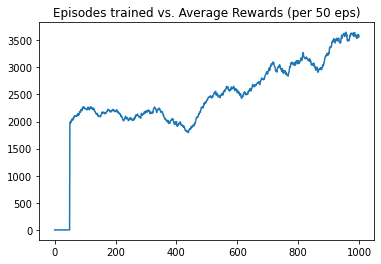

In [15]:
def run(training_mode, pretrained): 
    observation_space = env.observation_space.shape
    action_space = env.action_space.n
    agent = DQNAgent(state_space=observation_space,
                     action_space=action_space,
                     max_memory_size=30000,
                     batch_size=32,
                     gamma=0.90,
                     lr=0.00025,
                     dropout=0.,
                     exploration_max=1.0,
                     exploration_min=0.02,
                     exploration_decay=0.99,
                     double_dq=True,
                     pretrained=pretrained)
    
    num_episodes = 1000
    env.reset()
    total_rewards = []
    
    for ep_num in tqdm(range(num_episodes)):
        state = env.reset()
        state = torch.Tensor([state])
        total_reward = 0
        steps = 0
        while True:
            if not training_mode:
                show_state(env, ep_num)
            action = agent.act(state)
            steps += 1
            
            state_next, reward, terminal, info = env.step(int(action[0]))
            total_reward += reward
            state_next = torch.Tensor([state_next])
            reward = torch.tensor([reward]).unsqueeze(0)
            
            terminal = torch.tensor([int(terminal)]).unsqueeze(0)
            
            if training_mode:
                agent.remember(state, action, reward, state_next, terminal)
                agent.experience_replay()
            
            state = state_next
            if terminal:
                break
        
        total_rewards.append(total_reward)

        print("Total reward after episode {} is {}".format(ep_num + 1, total_rewards[-1]))
        num_episodes += 1      
    
    if training_mode:
        with open("ending_position.pkl", "wb") as f:
            pickle.dump(agent.ending_position, f)
        with open("num_in_queue.pkl", "wb") as f:
            pickle.dump(agent.num_in_queue, f)
        with open("total_rewards.pkl", "wb") as f:
            pickle.dump(total_rewards, f)
        if agent.double_dq:
            torch.save(agent.local_net.state_dict(), "dq1.pt")
            torch.save(agent.target_net.state_dict(), "dq2.pt")
        else:
            torch.save(agent.dqn.state_dict(), "dq.pt")  
        torch.save(agent.STATE_MEM,  "STATE_MEM.pt")
        torch.save(agent.ACTION_MEM, "ACTION_MEM.pt")
        torch.save(agent.REWARD_MEM, "REWARD_MEM.pt")
        torch.save(agent.STATE2_MEM, "STATE2_MEM.pt")
        torch.save(agent.DONE_MEM,   "DONE_MEM.pt")
    
    env.close()
    
    if num_episodes > 50:
        plt.title("Episodes trained vs. Average Rewards (per 50 eps)")
        plt.plot([0 for _ in range(50)] + 
                 np.convolve(total_rewards, np.ones((50,))/50, mode="valid").tolist())
        plt.show()

run(training_mode=True, pretrained=False)